#**Introducción A Ciencia De Datos Y Machine Learning Con Python | E2ICD9**

**Integrantes:**



*   Arizaba Garcia Topacio

*   Silva Ruiz Yanira
*   Vega castro Angie


*   Vasquez Milian Andy


**Profesor:** Luis Jose Zapata Bobadilla

**Universidad de Piura**

## Pregunta de investigación

***¿Cuál es la influencia de la tasa de interés de referencia en la dinámica de la inflación subyacente en el corto plazo en el Perú?***

Este trabajo analiza la dinámica de la inflación subyacente interanual en el Perú desde una perspectiva de **modelado predictivo**, con énfasis en el rol de la política monetaria y las expectativas inflacionarias. El objetivo no es realizar inferencia causal, sino evaluar la capacidad de distintos modelos estadísticos y de *machine learning* para anticipar la evolución de la inflación subyacente en el corto plazo (*nowcasting*).


## Objetivo del estudio

El objetivo principal es **evaluar y comparar el desempeño predictivo** de distintos modelos —lineales y no lineales— para estimar la inflación subyacente interanual, utilizando información macroeconómica y variables de política monetaria del Banco Central de Reserva del Perú (BCRP).

El análisis se desarrolla bajo un enfoque estrictamente predictivo, priorizando:
- La consistencia temporal,
- La evaluación fuera de muestra,
- Y la estabilidad de los modelos en un contexto de alta persistencia inflacionaria.


## Definición del período y variables

### Período de análisis

- **Inicio:** Enero de 2013  
- **Fin:** Agosto de 2025  

Este período abarca distintos regímenes de política monetaria, incluyendo fases de inflación baja y estable, así como episodios de mayor volatilidad asociados a shocks externos y al ciclo inflacionario posterior a la pandemia, lo que permite evaluar el desempeño de los modelos en contextos macroeconómicos diversos.


### Variables utilizadas

Las variables empleadas provienen del **API oficial del BCRP** y se agrupan según su rol económico:

**Inflación y expectativas**
- **PN01279PM:** Inflación subyacente interanual  
- **PD12912AM:** Expectativas de inflación a 12 meses  

**Política monetaria y tasas de interés**
- **PD04722MM:** Tasa de interés de referencia (TIR)  
- **PN07819NM:** Tasa de interés interbancaria promedio  
- **PD04724MM:** Tasa de los depósitos overnight en moneda nacional  

**Instrumentos de liquidez del BCRP**
- **PN06522TM:** Repo de valores – saldo  
- **PN06534TM:** Depósitos públicos – saldo  
- **PN06502OM:** Certificados de Depósito del BCRP (CDBCR) – saldo total  
- **PN06503OM:** CDBCR – tasa de interés  
- **PN07150NM:** Depósitos overnight del BCRP (promedio diario, empresas bancarias)

Estas variables permiten capturar tanto la postura de la política monetaria como sus mecanismos operativos de transmisión hacia la inflación subyacente.


# **TG 1. Análisis exploratorio de datos**

### **1.1. Carga de Librerías**

In [32]:
# Primero, importamos las librerías que necesitaremos
import requests  # La librería estándar en Python para hacer peticiones a la web
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import os                   # Módulo para interactuar con el sistema operativo
import warnings
import sklearn, statsmodels
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV          # Ridge y Ridge con validación cruzada
from sklearn.pipeline import Pipeline                    # Para encadenar pasos (escalado + modelo)
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson


## **1.2. Carga de series y definicion de parámetros**

In [33]:
# 1. Definimos los parámetros de nuestra consulta
codigos = 'PD04722MM-PN07819NM-PN06522TM-PN06534TM-PN06502OM-PN06503OM-PN07150NM-PD04724MM-PN01279PM-PD12912AM'
formato = 'json' # Pedimos los datos en formato JSON
periodo_inicial = '2013-01'
periodo_final = '2025-08'

# 2. Construimos la URL completa
url = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/{codigos}/{formato}/{periodo_inicial}/{periodo_final}"

# 3. Hacemos la petición GET a la web del BCRP
response = requests.get(url)

# 4. Verificamos que la petición fue exitosa (un código 200 significa que todo salió bien)
if response.status_code == 200:
    print("¡Conexión exitosa con el API del BCRP!")
    # Convertimos la respuesta a un formato de diccionario de Python
    data = response.json()
else:
    print(f"Error al conectar con el API. Código de estado: {response.status_code}")
    data = None

¡Conexión exitosa con el API del BCRP!


### **1.2.1. Inspección de la estructura de los datos sin procesar**

Antes de transformar los datos obtenidos desde la API del BCRP a un formato estructurado (por ejemplo, un `DataFrame` de *pandas*), se realizó una inspección preliminar de los datos sin procesar con el objetivo de comprender su organización interna y asegurar una correcta extracción de la información.

En particular, se examinaron las dos primeras observaciones y la última entrada del objeto `data['periods']`. Este procedimiento permitió verificar los siguientes aspectos clave:

- El **formato de la información temporal**, donde cada observación contiene una etiqueta de período (por ejemplo, *Ene.2013*), que posteriormente se convertirá en la columna de fecha del conjunto de datos.
- La forma en que los **valores de las variables** se almacenan como una lista asociada a cada período.
- El **orden consistente** de las variables dentro de dicha lista, lo cual es fundamental para asignar correctamente cada valor a su respectiva columna (tasa de referencia, inflación, instrumentos monetarios, entre otros).

La inspección confirmó que los datos están estructurados como una secuencia de períodos mensuales, donde cada período contiene una fecha y un vector de valores correspondientes a las distintas variables macroeconómicas, manteniendo un orden fijo a lo largo del tiempo. Esta validación es un paso esencial para evitar errores de alineación o etiquetado en la construcción del `DataFrame`, y garantiza la consistencia del dataset que será utilizado en las etapas posteriores de análisis y modelado.


In [34]:
# Miremos los datos de los primeros dos periodos para entender la estructura
#[Tasa_Ref, Tasa_Depositos_Overnight, Inflación_Mensual_Subyacente_12m, Expectativas_Inflacion_12m,	CDBCR_Total_Saldo,	CDBCR_Saldo_TIR,	Repos_Valores, Depositos_Publicos, Depositos_Overnight, Tasa_Interbancaria]
if data:
    print(data['periods'][0])
    print(data['periods'][1])
    print(data['periods'][-1])

{'name': 'Ene.2013', 'values': ['4.25', '3.45', '2.59166666666667', '3.3380626594732', '36762.4', '4.053', '0', '0', '367807', '4.1518']}
{'name': 'Feb.2013', 'values': ['4.25', '3.45', '2.575', '3.22198998409693', '36200.2', '4.03', '0', '0', '47590', '4.2008']}
{'name': 'Ago.2025', 'values': ['4.5', '2.5', '2.18333333333333', '2.09918594926549', '43991.9', '4.2065169497112', '7306.825629', '4024.9', '78929.5483870968', '4.5079']}


### **1.2.2. Estructuración de los datos en un DataFrame**

En esta etapa se transforman los datos sin procesar obtenidos desde la API del BCRP —almacenados como una lista de diccionarios— en un `DataFrame` estructurado de *pandas*, que servirá como base para todo el análisis posterior.

El procedimiento sigue una lógica explícita y controlada para garantizar la correcta alineación temporal y la integridad de las variables:

- Se inicializan listas vacías para cada variable macroeconómica y de política monetaria, que permiten almacenar temporalmente los valores extraídos.
- Se itera sobre cada período mensual contenido en `data['periods']`, extrayendo:
  - La etiqueta temporal del período, que posteriormente se convertirá en la variable de fecha.
  - El vector de valores asociado a cada período, el cual mantiene un orden fijo determinado por los códigos solicitados en la llamada a la API.
- Cada valor es convertido a tipo numérico (`float`) cuando está disponible. En los casos en que la API reporta valores no disponibles (`'n.d.'`), estos se reemplazan por `NaN`, permitiendo un tratamiento consistente de los datos faltantes en las etapas posteriores.
- Los valores procesados se almacenan en sus respectivas listas, preservando el orden temporal original de las observaciones.

Una vez procesados todos los períodos, las listas se consolidan en un diccionario cuyas claves corresponden a los nombres finales de las variables, y se construye el `DataFrame` definitivo. La inspección de las primeras filas permite verificar rápidamente la estructura del conjunto de datos y confirmar que las variables han sido correctamente asignadas.

In [35]:
if data:
    # Creamos listas vacías
    fechas = []
    tir = []
    tover = []
    inflación_subyacente_var12m = []
    expectativas_inflacion = []
    cdbcr_total = []
    cdbcr_tir = []
    repos_valores = []
    depositos_publicos = []
    depositos_overnight = []
    interbancaria = []


    # Iteramos sobre los periodos en los datos del BCRP
    for periodo in data['periods']:
        fechas.append(periodo['name'])

        # Los valores vienen en el mismo orden en que pusiste los códigos en la URL:
        # PN38705PM - PD04722MM - PN07839NM - PN06525TM - PN06534TM
        valores = periodo['values']

        # Tasa de interés de referencia
        tir.append(float(valores[0]) if valores[0] != 'n.d.' else np.nan)
        # Depósitos overnight
        tover.append(float(valores[1]) if valores[1] != 'n.d.' else np.nan)
        # Inflación subyacente
        inflación_subyacente_var12m.append(float(valores[2]) if valores[2] != 'n.d.' else np.nan)
        # Expectativas de inflacion
        expectativas_inflacion.append(float(valores[3]) if valores[3] != 'n.d.' else np.nan)
        # CDBCR total saldo
        cdbcr_total.append(float(valores[4]) if valores[4] != 'n.d.' else np.nan)
        # CDBCR saldo tasa de interés
        cdbcr_tir.append(float(valores[5]) if valores[5] != 'n.d.' else np.nan)
        # Repos (saldo)
        repos_valores.append(float(valores[6]) if valores[6] != 'n.d.' else np.nan)
        # Depósitos públicos (saldo)
        depositos_publicos.append(float(valores[7]) if valores[7] != 'n.d.' else np.nan)
        # Depósitos overnight BCR
        depositos_overnight.append(float(valores[8]) if valores[8] != 'n.d.' else np.nan)
        # Tasa interbancaria promedio
        interbancaria.append(float(valores[9]) if valores[9] != 'n.d.' else np.nan)



    # Construimos el DataFrame
    datos_para_df = {
        'Fecha': fechas,
        'Tasa_Ref (%)': tir,
        'Tasa_Depositos_Overnight (%)': tover,
        'Inflación_Mensual_Subyacente_12m (%)': inflación_subyacente_var12m,
        'Expectativas_Inflacion_12m (%)': expectativas_inflacion,
        'CDBCR_Total_Saldo (S/ millones)': cdbcr_total,
        'CDBCR_Saldo_TIR (%)': cdbcr_tir,
        'Repos_Valores (S/ millones)': repos_valores,
        'Depositos_Publicos_Saldo (S/ millones)': depositos_publicos,
        'Depositos_Overnight_BCR (S/ miles)': depositos_overnight,
        'Tasa_Interbancaria (%)': interbancaria,

    }

    df_bcrp = pd.DataFrame(datos_para_df)

    print("DataFrame creado exitosamente:")
    display(df_bcrp.head())
else:
    print("No se pudieron cargar los datos para crear el DataFrame.")


DataFrame creado exitosamente:


,Fecha,Tasa_Ref (%),Tasa_Depositos_Overnight (%),Inflación_Mensual_Subyacente_12m (%),Expectativas_Inflacion_12m (%),CDBCR_Total_Saldo (S/ millones),CDBCR_Saldo_TIR (%),Repos_Valores (S/ millones),Depositos_Publicos_Saldo (S/ millones),Depositos_Overnight_BCR (S/ miles),Tasa_Interbancaria (%)
0,Ene.2013,4.25,3.45,2.591667,3.338063,36762.4,4.053,0.0,0.0,367807.0,4.1518
1,Feb.2013,4.25,3.45,2.575000,3.221990,36200.2,4.030,0.0,0.0,47590.0,4.2008
2,Mar.2013,4.25,3.45,2.562500,3.477736,36034.7,3.960,0.0,0.0,201773.0,4.2404
3,Abr.2013,4.25,3.45,2.483333,3.404137,37175.0,3.970,0.0,0.0,122430.0,4.2005
4,May.2013,4.25,3.45,2.479167,3.318773,33493.0,3.860,0.0,0.0,23520.0,4.2542


### **1.2.3. Limpieza de datos y descripción del dataset**

En esta etapa se realiza una limpieza básica del conjunto de datos con el objetivo de garantizar la consistencia y completitud de las observaciones que serán utilizadas en el análisis descriptivo y el modelado predictivo.

En particular, se eliminan aquellas filas que contienen valores faltantes (`NaN`) en al menos una de las variables. Esta decisión se justifica por dos razones principales:

- La proporción de valores faltantes es reducida y se concentra en períodos específicos, por lo que su eliminación no compromete de manera significativa el tamaño muestral.
- Los modelos que se estimarán posteriormente (tanto econométricos como de *machine learning*) requieren observaciones completas para asegurar una correcta estimación y evaluación fuera de muestra.

La operación se realiza directamente sobre el `DataFrame`, y a continuación se utiliza `df_bcrp.info()` para verificar la estructura resultante del dataset, confirmando el número de observaciones disponibles y la ausencia de valores faltantes en las variables seleccionadas.

El conjunto de datos resultante constituye una base limpia y coherente para el análisis exploratorio y la formulación del problema predictivo en las siguientes secciones.



In [36]:
# Eliminar las filas con valores faltantes en cualquier columna
df_bcrp.dropna(inplace=True)

# Verificar nuevamente el estado del DataFrame
df_bcrp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 11 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Fecha                                   152 non-null    object 
 1   Tasa_Ref (%)                            152 non-null    float64
 2   Tasa_Depositos_Overnight (%)            152 non-null    float64
 3   Inflación_Mensual_Subyacente_12m (%)    152 non-null    float64
 4   Expectativas_Inflacion_12m (%)          152 non-null    float64
 5   CDBCR_Total_Saldo (S/ millones)         152 non-null    float64
 6   CDBCR_Saldo_TIR (%)                     152 non-null    float64
 7   Repos_Valores (S/ millones)             152 non-null    float64
 8   Depositos_Publicos_Saldo (S/ millones)  152 non-null    float64
 9   Depositos_Overnight_BCR (S/ miles)      152 non-null    float64
 10  Tasa_Interbancaria (%)                  152 non-null    float6

In [37]:
df_bcrp.describe()

,Tasa_Ref (%),Tasa_Depositos_Overnight (%),Inflación_Mensual_Subyacente_12m (%),Expectativas_Inflacion_12m (%),CDBCR_Total_Saldo (S/ millones),CDBCR_Saldo_TIR (%),Repos_Valores (S/ millones),Depositos_Publicos_Saldo (S/ millones),Depositos_Overnight_BCR (S/ miles),Tasa_Interbancaria (%)
count,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,1.520000e+02,152.000000
mean,3.797697,2.486513,2.824608,3.393059,33746.351974,3.846919,5568.981576,2801.742105,8.239607e+05,3.827607
std,1.932369,1.348496,0.781864,1.296185,14455.399160,1.769391,4366.902332,2167.146173,1.257515e+06,1.936193
min,0.250000,0.150000,1.400000,1.560852,12757.200000,0.364835,0.000000,0.000000,2.352000e+04,0.110600
25%,2.750000,1.500000,2.359844,2.330659,25491.550000,2.800000,1900.000000,1154.750000,2.531599e+05,2.752650
50%,4.000000,2.500000,2.639583,3.304712,30080.050000,3.870000,5054.266810,2500.100000,4.366190e+05,3.963500
75%,4.500000,3.250000,3.088333,3.934795,41028.975000,4.666141,8485.396000,4158.825000,7.834652e+05,4.533500
max,7.750000,5.250000,5.350000,6.769600,81435.000000,7.571590,15654.446000,7044.400000,8.106778e+06,7.761200


### **1.2.4. Detección de posibles outliers**

Con el objetivo de identificar observaciones extremas que puedan influir en el análisis descriptivo y en el desempeño de los modelos predictivos, se realizó una detección preliminar de posibles valores atípicos (*outliers*) en las variables numéricas del conjunto de datos, utilizando el criterio del rango intercuartílico (IQR).

Bajo este enfoque, se consideran outliers aquellas observaciones que se encuentran fuera del intervalo:

$$
[Q1 - 1.5 \cdot IQR,\; Q3 + 1.5 \cdot IQR]
$$

Donde $Q1$ y $Q3$ corresponden al primer y tercer cuartil de cada variable, respectivamente. Este método no impone supuestos paramétricos sobre la distribución de los datos, lo que resulta apropiado en un contexto macroeconómico caracterizado por cambios de régimen y episodios excepcionales.

Los resultados evidencian la presencia de observaciones clasificadas como outliers en variables clave como la inflación subyacente interanual, la tasa de referencia y la tasa interbancaria, así como en algunas variables de liquidez. Estos valores extremos no se interpretan como errores de medición, sino como episodios económicos relevantes, asociados a ajustes discretos de la política monetaria, shocks macroeconómicos o intervenciones puntuales del BCRP.

Es por ello que no se eliminan observaciones en esta etapa. La conservación de estos valores es coherente con el enfoque predictivo del trabajo, dado que dichos episodios contienen información relevante sobre la dinámica inflacionaria y los mecanismos de transmisión de la política monetaria.



In [38]:
# Seleccionar solo las columnas numéricas
columnas_numericas = df_bcrp.select_dtypes(include=['float64', 'int64'])

# Calcular el IQR solo para las columnas numéricas
Q1 = columnas_numericas.quantile(0.25)
Q3 = columnas_numericas.quantile(0.75)
IQR = Q3 - Q1

# Detectar outliers
outliers = ((columnas_numericas < (Q1 - 1.5 * IQR)) | (columnas_numericas > (Q3 + 1.5 * IQR))).sum()

# Mostrar el conteo de outliers por variable
print("Cantidad de posibles outliers por variable:")
print(outliers)

Cantidad de posibles outliers por variable:
Tasa_Ref (%)                              12
Tasa_Depositos_Overnight (%)               0
Inflación_Mensual_Subyacente_12m (%)      15
Expectativas_Inflacion_12m (%)             8
CDBCR_Total_Saldo (S/ millones)           10
CDBCR_Saldo_TIR (%)                        6
Repos_Valores (S/ millones)                0
Depositos_Publicos_Saldo (S/ millones)     0
Depositos_Overnight_BCR (S/ miles)        18
Tasa_Interbancaria (%)                    11
dtype: int64


## **1.3. Principales Gráficos**



#### **1.3.1. Boxplots**

Usamos boxplots para evaluar si existen diferencias sistemáticas entre variables de precios y tasas de interés, por un lado, y variables de saldos monetarios, por otro. Dado el carácter administrado de la política monetaria, se espera que las tasas de interés presenten distribuciones relativamente concentradas, mientras que la inflación subyacente y las variables de liquidez podrían exhibir mayor dispersión o asimetría.

El análisis visual de los boxplots servirá como base para la interpretación económica de los resultados y para evaluar la pertinencia de conservar observaciones extremas en el modelado posterior.



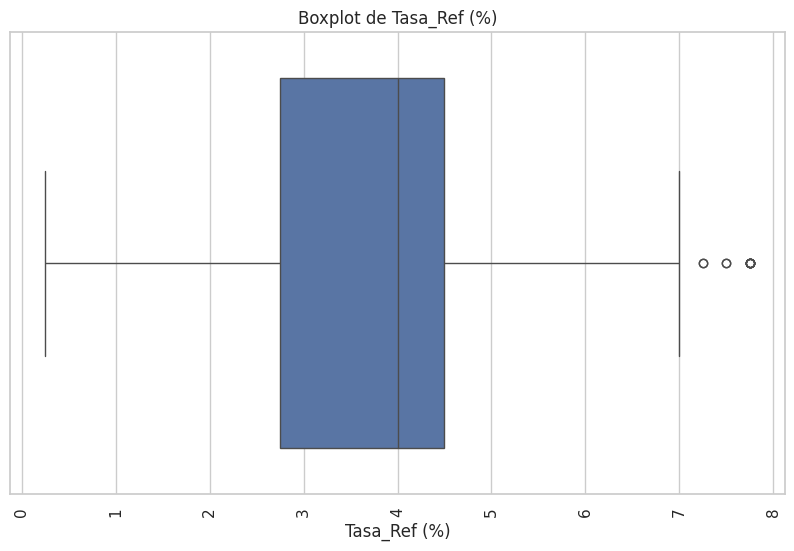

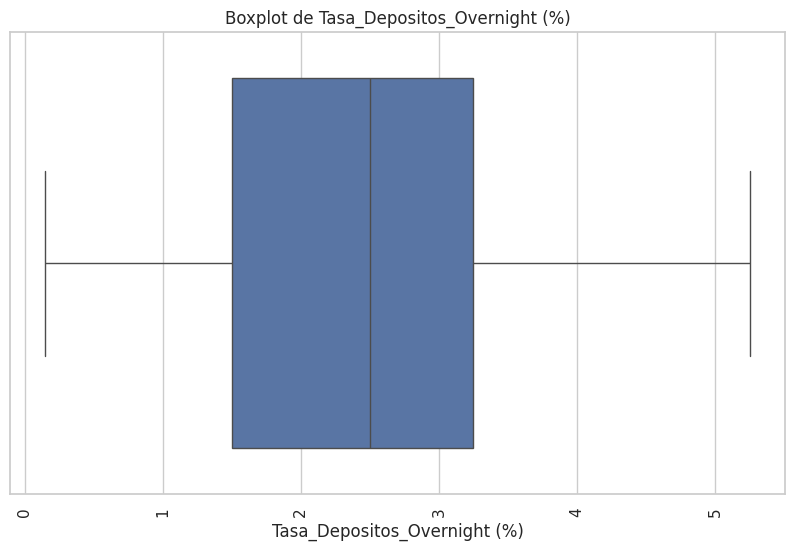

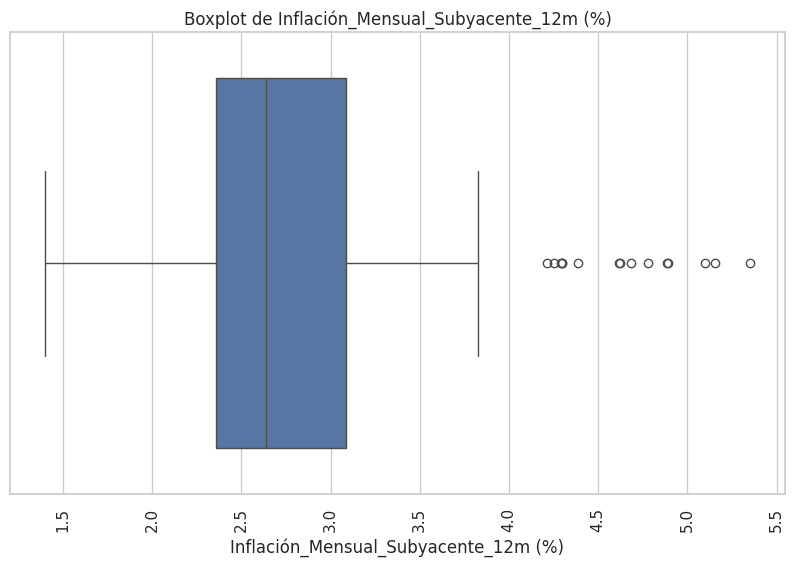

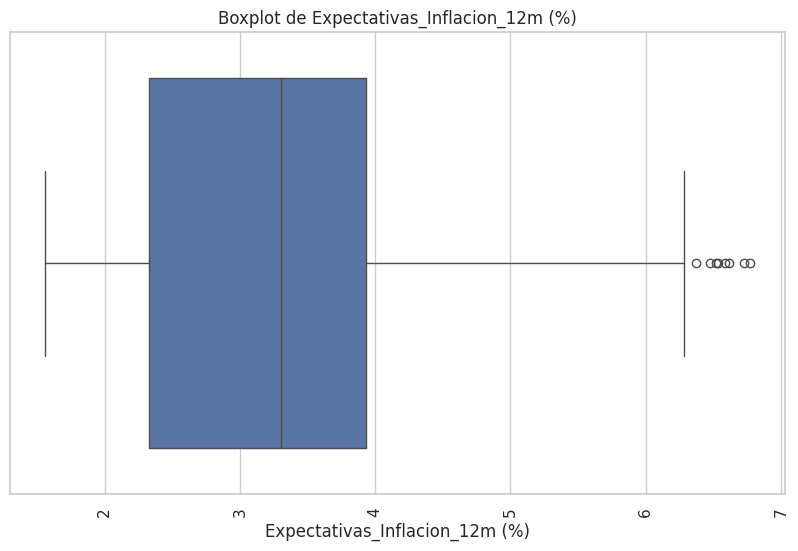

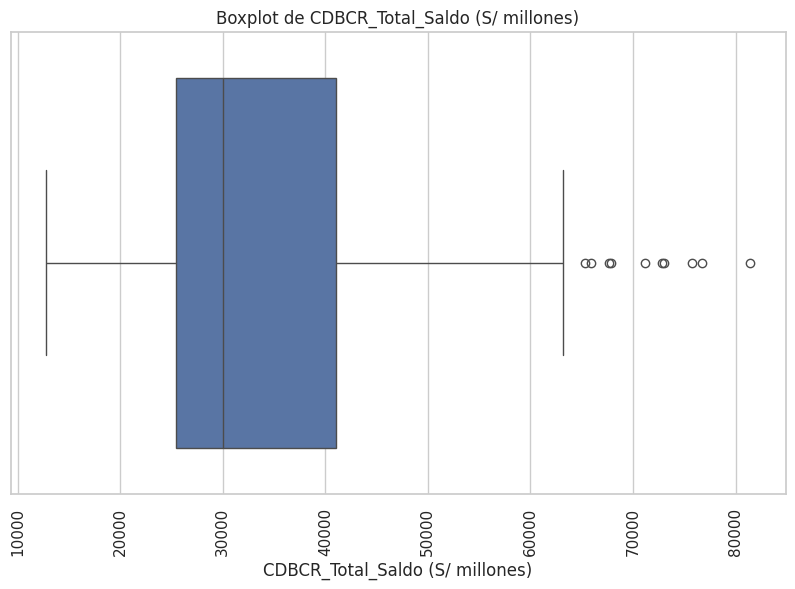

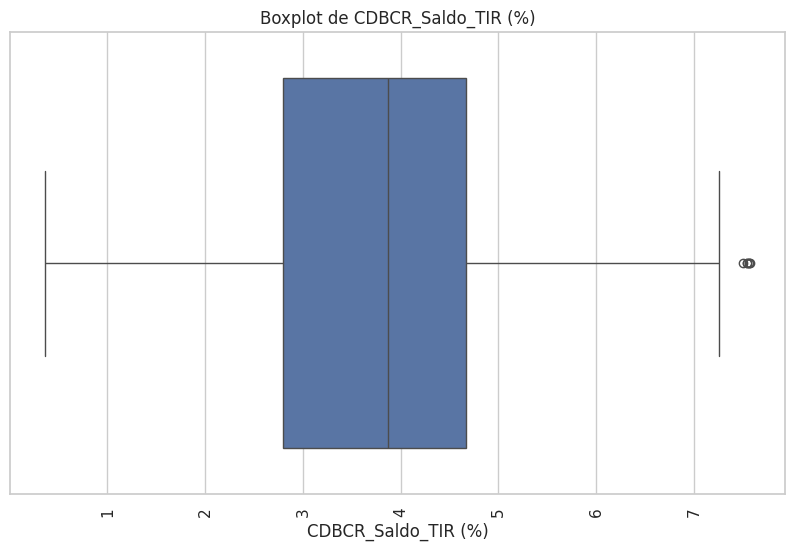

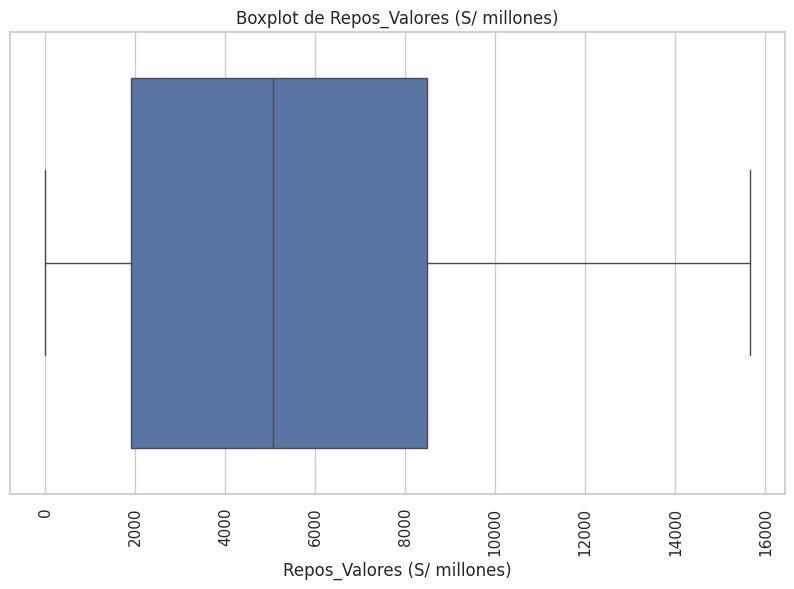

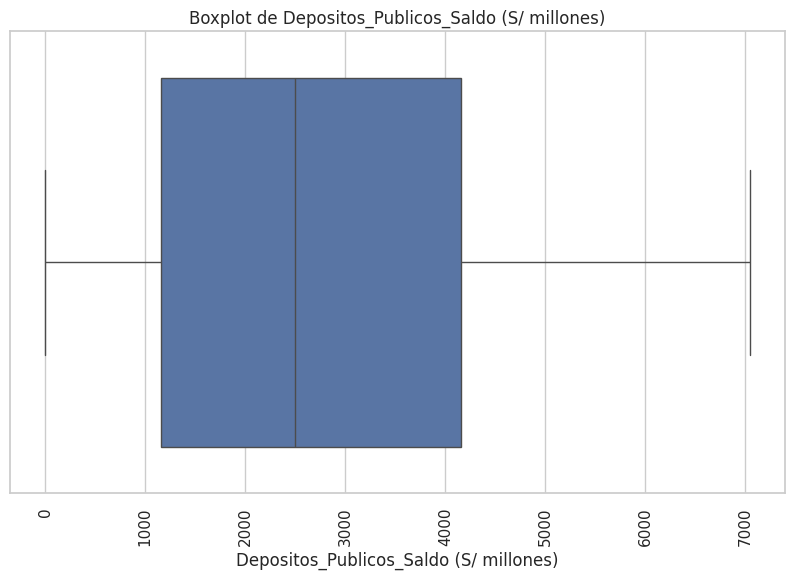

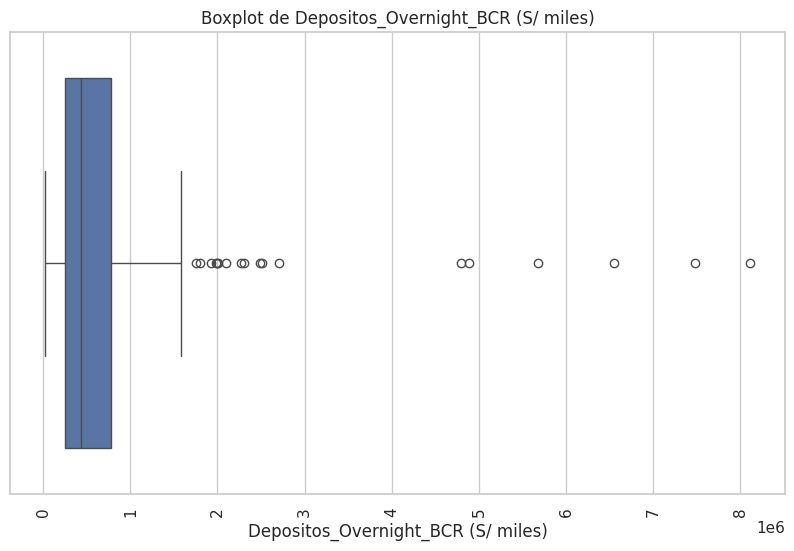

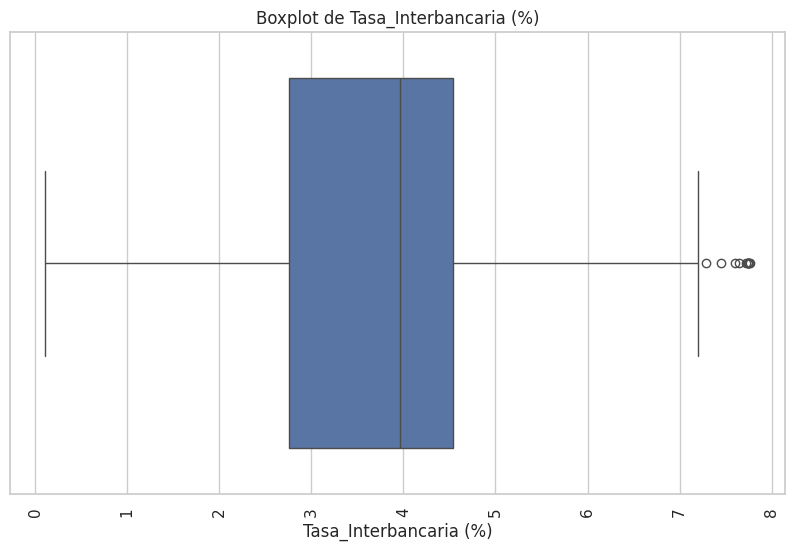

In [39]:
# Definir las columnas numéricas de interés
variables = columnas_numericas.columns

# Crear un boxplot por cada variable
for var in variables:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df_bcrp[var])
    plt.title(f'Boxplot de {var}')
    plt.xticks(rotation=90)  # Rotar las etiquetas del eje X para mejor visibilidad
    plt.show()


Los boxplots permiten identificar no solo la dispersión de cada variable, sino también la naturaleza estructural de su volatilidad. En particular, se observa una clara diferenciación entre variables de precios/tasas y variables de saldos monetarios.

Las tasas de interés de política y de mercado (Tasa de Referencia, Tasa Interbancaria, Tasa de interés de los CDBCR y Tasa de interés de Depósitos Overnight) presentan distribuciones altamente concentradas, con rangos intercuartílicos estrechos. Esto refleja el carácter discrecional y administrado de la política monetaria del BCRP, donde los ajustes se realizan en escalones y con baja volatilidad intramensual.
Los valores atípicos observados en estas tasas no corresponden a errores de medición, sino a episodios específicos de cambios de régimen monetario, particularmente durante periodos de endurecimiento de la política para contener presiones inflacionarias.

Además, la inflación subyacente interanual muestra una dispersión relativamente reducida (IQR estrecho) con mediana cercana a 2.8% y algunos outliers superiores, lo que indica estabilidad central pero sensibilidad a shocks persistentes cuando ocurren; las expectativas de inflación, en cambio, presentan mayor dispersión y una cola derecha pronunciada, señalando heterogeneidad entre agentes. Las variables de saldos monetarios (CDBCR, repos y depósitos públicos) exhiben distribuciones asimétricas con numerosos valores extremos superiores, patrón coherente con el carácter operativo del banco central, donde grandes movimientos de liquidez aparecen de forma episódica en respuesta a tensiones específicas del sistema financiero.


### **1.3.2. Tendencias**

En esta sección se representan las series mensuales en función del tiempo, una vez estandarizado el formato de fechas, con el objetivo de evaluar la persistencia de la inflación subyacente, la dinámica de las tasas de interés y el comportamiento de los instrumentos de política monetaria y liquidez.

El análisis visual de estas trayectorias servirá como base para la interpretación económica de los movimientos observados y para justificar la inclusión de rezagos y validación temporal en el modelado predictivo posterior.


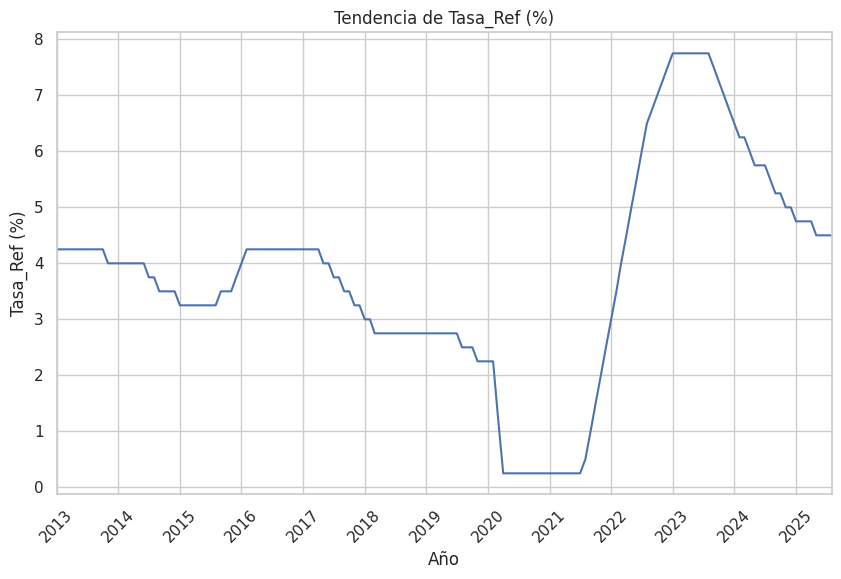

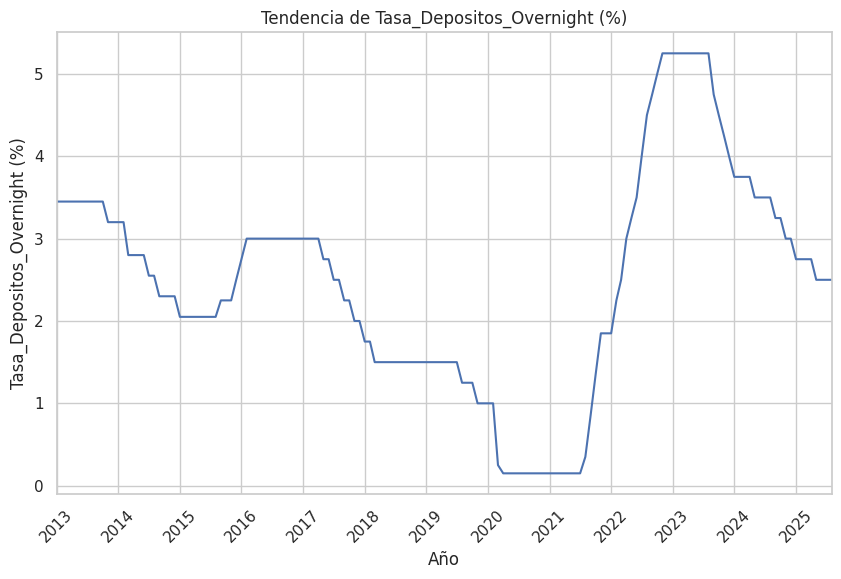

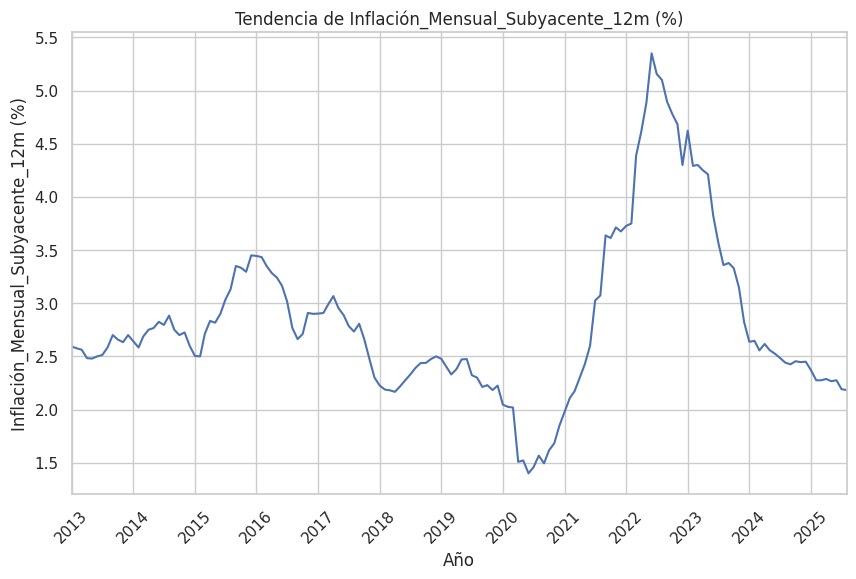

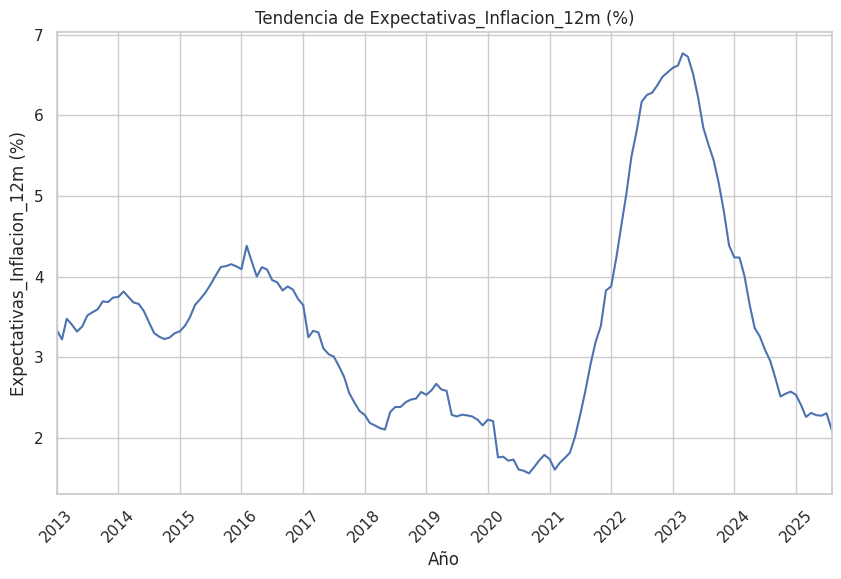

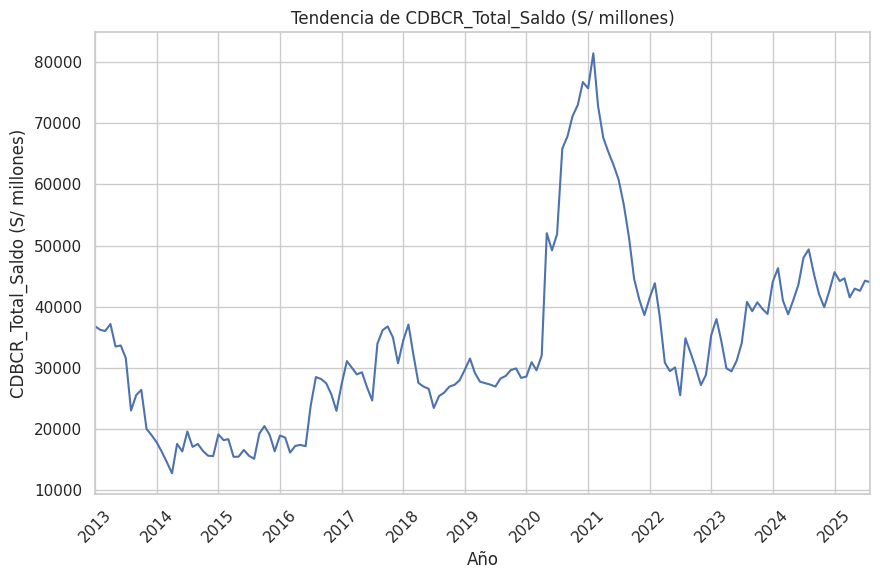

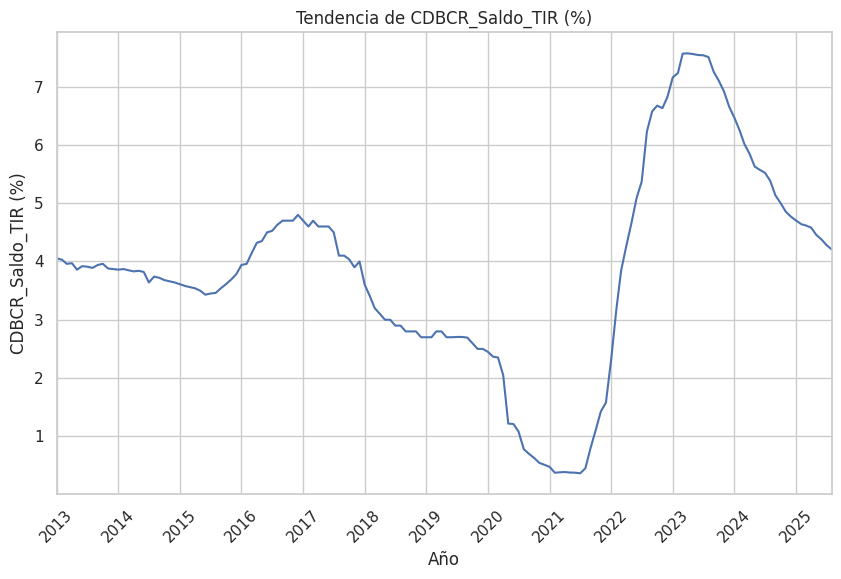

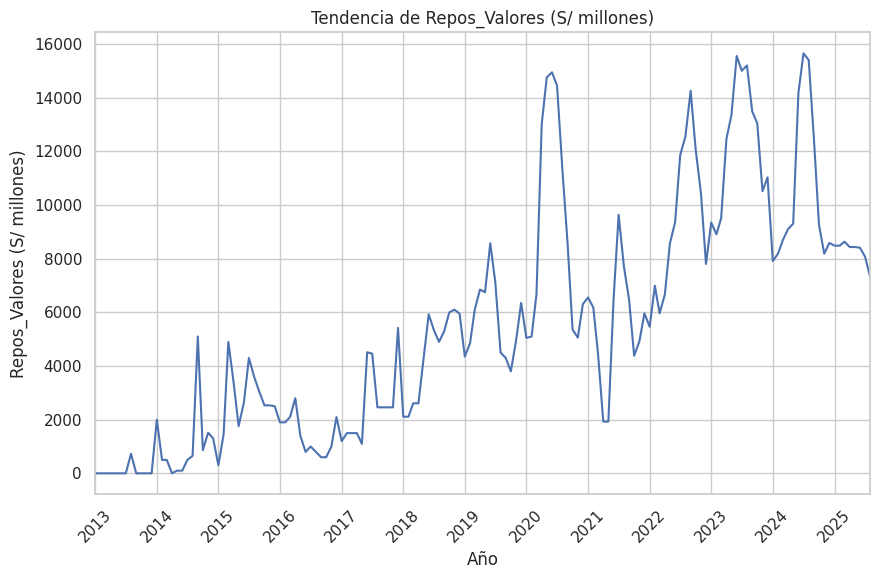

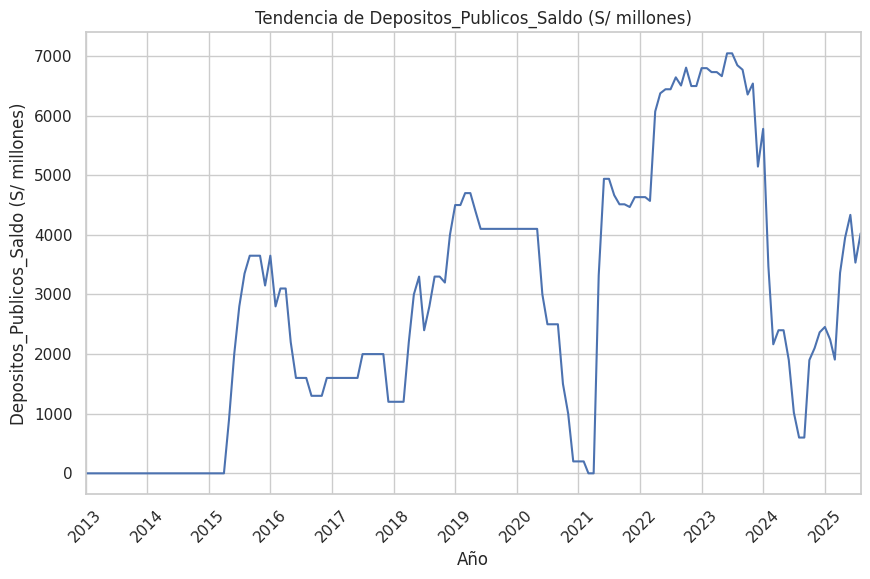

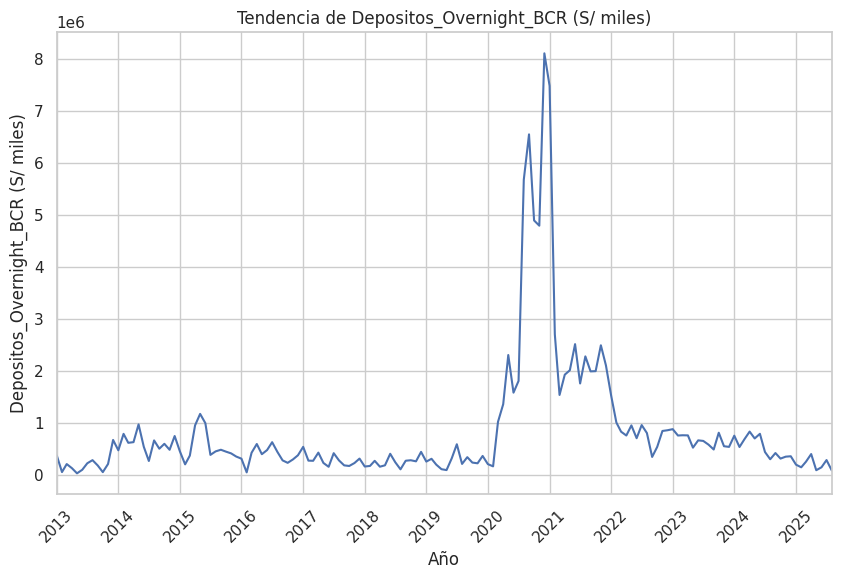

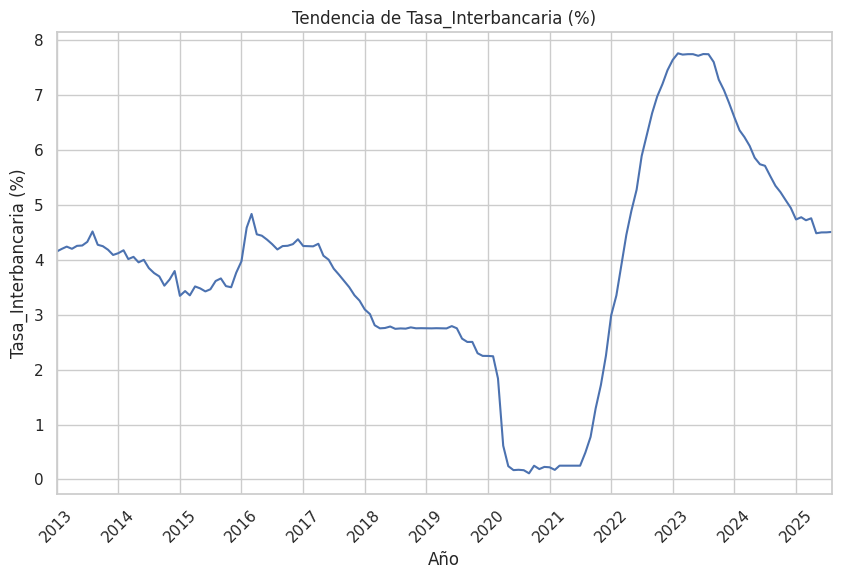

In [40]:

# Crear un diccionario para mapear los meses en español al formato en inglés
meses_esp = {
    'Ene': 'Jan', 'Feb': 'Feb', 'Mar': 'Mar', 'Abr': 'Apr', 'May': 'May', 'Jun': 'Jun',
    'Jul': 'Jul', 'Ago': 'Aug', 'Sep': 'Sep', 'Oct': 'Oct', 'Nov': 'Nov', 'Dic': 'Dec'
}

# Función para convertir las fechas en español al formato inglés
def convertir_mes(fecha):
    mes, año = fecha.split('.')
    mes = meses_esp[mes]  # Reemplazar el mes en español por su equivalente en inglés
    return f'{mes}.{año}'

# Aplicar la función a la columna 'Fecha'
df_bcrp['Fecha'] = df_bcrp['Fecha'].apply(convertir_mes)
df_bcrp['Fecha'] = pd.to_datetime(df_bcrp['Fecha'], format='%b.%Y')

# Definir las columnas numéricas de interés
variables = columnas_numericas.columns

# Obtener el rango de fechas del DataFrame
fecha_min = df_bcrp['Fecha'].min()
fecha_max = df_bcrp['Fecha'].max()

# Crear un gráfico de tendencias para cada variable
for var in variables:
    plt.figure(figsize=(10, 6))

    # Graficar solo la línea, sin puntos
    plt.plot(df_bcrp['Fecha'], df_bcrp[var], linestyle='-', color='b')

    # Configurar el formato del eje X para mostrar solo el año
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Mostrar todos los años del rango de datos
    plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))  # Mostrar todos los años

    # Limitar el rango del eje X al mínimo y máximo de las fechas en el DataFrame
    plt.xlim([fecha_min, fecha_max])

    # Ajustes del gráfico
    plt.title(f'Tendencia de {var}')
    plt.xlabel('Año')
    plt.ylabel(var)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()



Interpretación

Las series temporales muestran una dinámica altamente coherente entre los distintos instrumentos de política monetaria del BCRP. La Tasa de Referencia, la Tasa Interbancaria y la Tasa de Depósitos Overnight presentan trayectorias prácticamente paralelas, lo que evidencia un mecanismo de transmisión monetaria efectivo, donde la tasa de política se propaga al resto del mercado monetario.

A partir de finales de 2021 se observa un cambio claro de régimen: un ciclo de endurecimiento monetario sostenido, consistente con el aumento de presiones inflacionarias globales y domésticas. Este comportamiento confirma que el BCRP respondió activamente para reanclar expectativas.

Las expectativas de inflación a 12 meses muestran un aumento persistente durante este mismo periodo, lo que sugiere que los agentes económicos internalizaron el entorno inflacionario adverso. La coexistencia de expectativas elevadas y tasas altas refuerza la hipótesis de una política monetaria activa y orientada a la estabilidad de precios.

En cuanto a los instrumentos de liquidez (CDBCR, Repos y Depósitos Públicos), se observa una volatilidad considerable, con episodios de expansión y contracción abrupta. Estos movimientos reflejan operaciones claves del BCRP para administrar la liquidez de corto plazo, más que cambios estructurales en la postura monetaria.
En conjunto, estas tendencias sugieren que la inflación subyacente, las expectativas y la tasa de referencia evolucionan de manera interdependiente, lo que justifica su inclusión conjunta en un modelo de nowcasting.


## **1.4. Matriz de correlación**

Utilizamos la matriz de correlación identificar patrones de co-movimiento entre la inflación subyacente, las tasas de interés y los instrumentos de política monetaria, así como anticipar posibles problemas de multicolinealidad que podrían afectar la estimación y comparación de modelos en etapas posteriores.


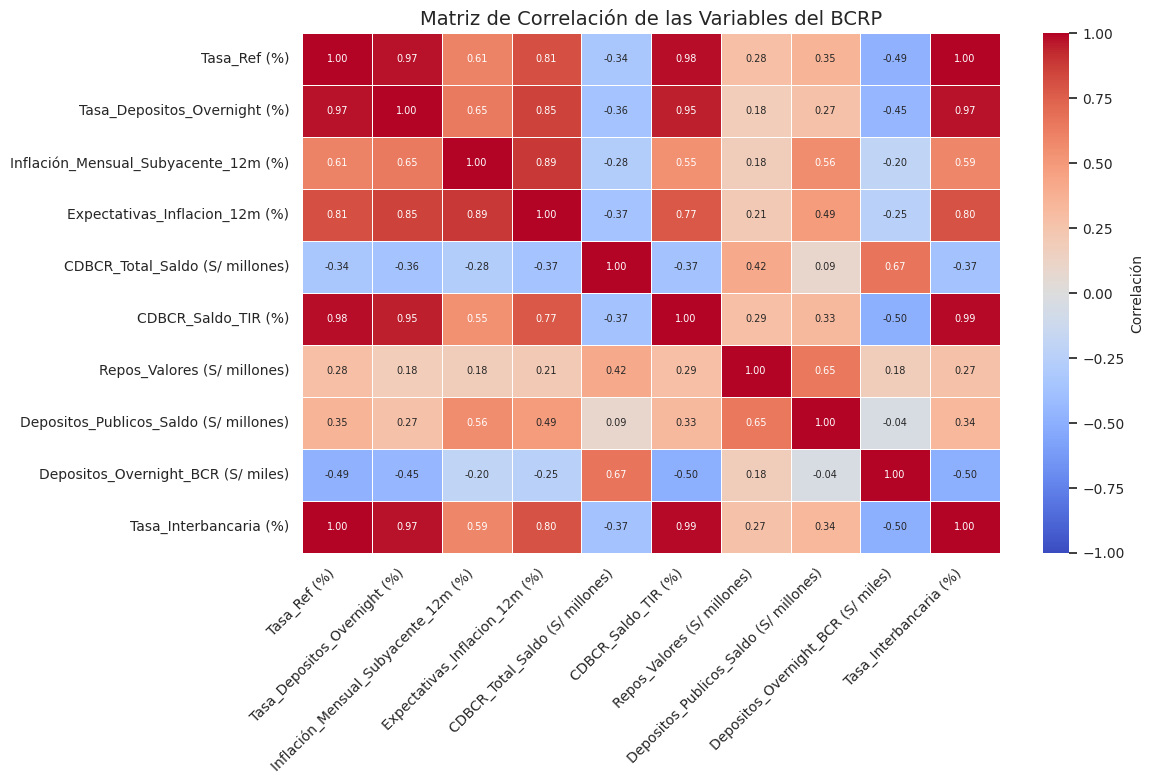

In [41]:

# Excluir la columna 'Fecha' para calcular la correlación solo con las variables numéricas
df_bcrp_sin_fecha = df_bcrp.drop(columns=['Fecha'])

# Calcular la matriz de correlación
correlacion = df_bcrp_sin_fecha.corr()


plt.figure(figsize=(12, 8))

# Crear el heatmap y guardar la barra de color en 'cbar'
ax = sns.heatmap(
    correlacion,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    linewidths=0.5,
    vmin=-1, vmax=1,
    annot_kws={"size": 7},      # Tamaño de letra dentro del heatmap
    cbar_kws={"label": "Correlación"}  # Etiqueta de la barra de color
)

# Ajustar la barra de color
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)          # Tamaño de letra de los números
cbar.ax.set_ylabel("Correlación", fontsize=10)  # Tamaño de la etiqueta

# Títulos y ejes
plt.title('Matriz de Correlación de las Variables del BCRP', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

plt.tight_layout()
plt.show()



La matriz de correlación evidencia una fuerte asociación positiva entre la inflación subyacente y la tasa de interés de referencia. Este resultado no debe interpretarse como causalidad directa, sino como el reflejo de la función de reacción del banco central: ante mayores presiones inflacionarias, el BCRP ajusta su tasa de política.

Asimismo, la elevada correlación entre la tasa de referencia, la tasa interbancaria y la tasa de depósitos overnight confirma la consistencia del canal de transmisión monetaria, donde la señal de política se propaga de manera casi mecánica hacia las tasas de corto plazo del sistema financiero.

En contraste, las correlaciones más débiles entre la inflación y las variables operativas de liquidez sugieren que estos instrumentos cumplen un rol principalmente táctico, mientras que la tasa de referencia y las expectativas inflacionarias constituyen los principales canales informativos del proceso inflacionario.


### **1.4.1. Correlación entre pares de variables**

Con el objetivo de profundizar en las relaciones más relevantes identificadas en la matriz de correlación, se analizan de manera explícita los pares de variables con correlaciones lineales elevadas.

Este ejercicio permite identificar vínculos estrechos entre variables clave, visualizar su grado de co-movimiento y anticipar posibles problemas de multicolinealidad que podrían afectar la estimación de modelos econométricos y de machine learning en etapas posteriores.


In [42]:

# Excluir la columna 'Fecha' para calcular solo las correlaciones de las variables numéricas
df_bcrp_sin_fecha = df_bcrp.drop(columns=['Fecha'])

# Calcular la matriz de correlación
correlacion = df_bcrp_sin_fecha.corr()

# Convertir la matriz de correlación en un formato largo (pairs de variables)
correlacion_larga = correlacion.unstack()

# Filtrar los pares con correlación absoluta mayor A 0.8
correlacion_fuerte = correlacion_larga[(correlacion_larga.abs() > 0.8) & (correlacion_larga != 1)]

# Ordenar los pares de correlación de mayor a menor
correlacion_fuerte = correlacion_fuerte.sort_values(ascending=False)

# Mostrar los pares de variables más correlacionadas
print("Pares de variables con correlación más alta:")
print(correlacion_fuerte)

Pares de variables con correlación más alta:
Tasa_Ref (%)                          Tasa_Interbancaria (%)                  0.997973
Tasa_Interbancaria (%)                Tasa_Ref (%)                            0.997973
CDBCR_Saldo_TIR (%)                   Tasa_Interbancaria (%)                  0.986235
Tasa_Interbancaria (%)                CDBCR_Saldo_TIR (%)                     0.986235
Tasa_Ref (%)                          CDBCR_Saldo_TIR (%)                     0.983514
CDBCR_Saldo_TIR (%)                   Tasa_Ref (%)                            0.983514
Tasa_Depositos_Overnight (%)          Tasa_Ref (%)                            0.974326
Tasa_Ref (%)                          Tasa_Depositos_Overnight (%)            0.974326
Tasa_Interbancaria (%)                Tasa_Depositos_Overnight (%)            0.971189
Tasa_Depositos_Overnight (%)          Tasa_Interbancaria (%)                  0.971189
CDBCR_Saldo_TIR (%)                   Tasa_Depositos_Overnight (%)            0.94977

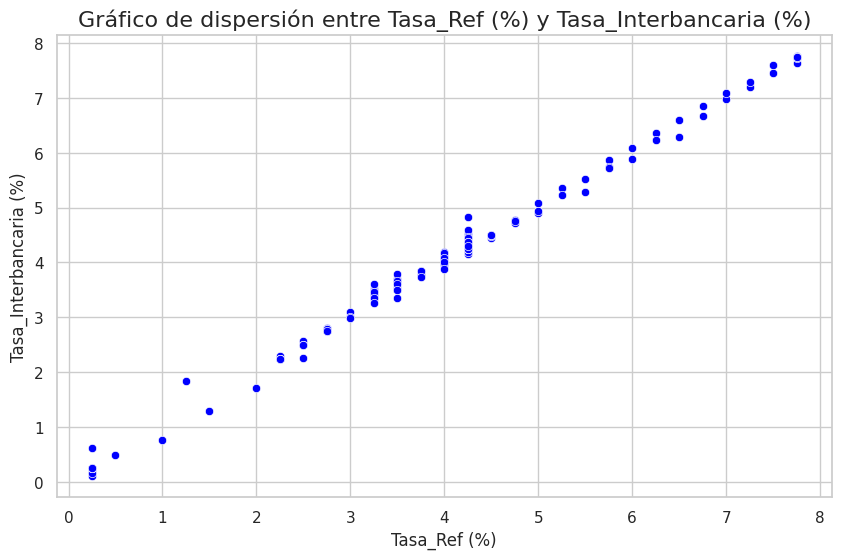

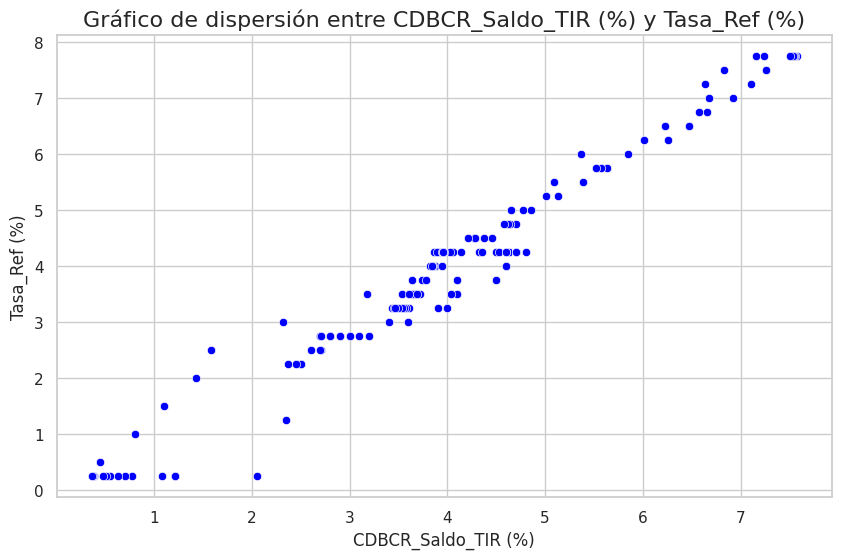

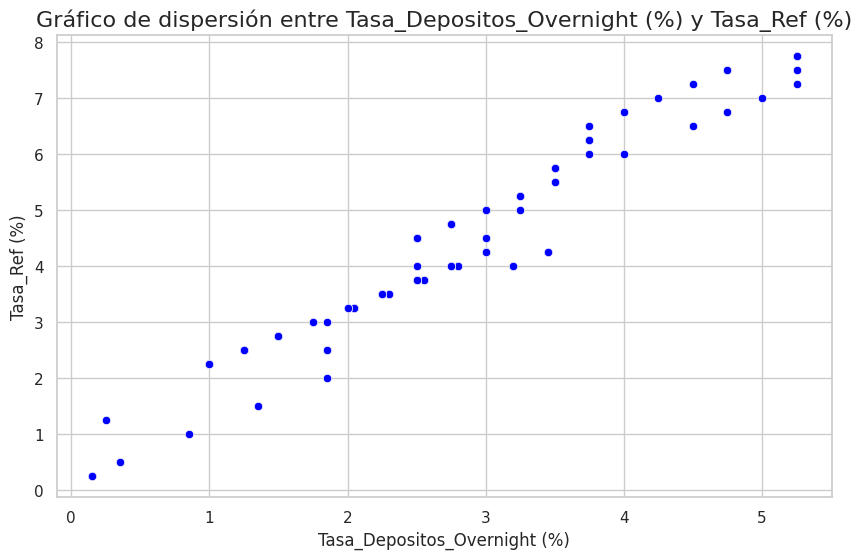

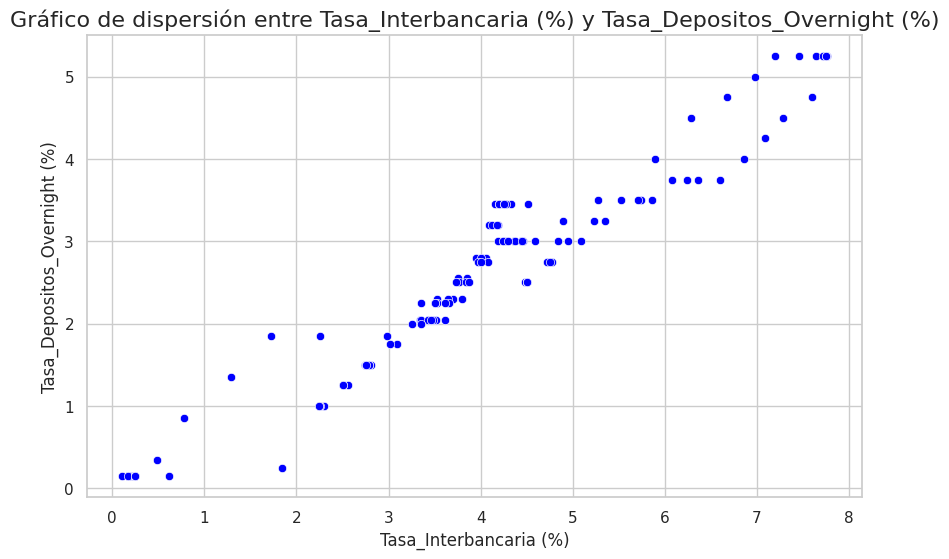

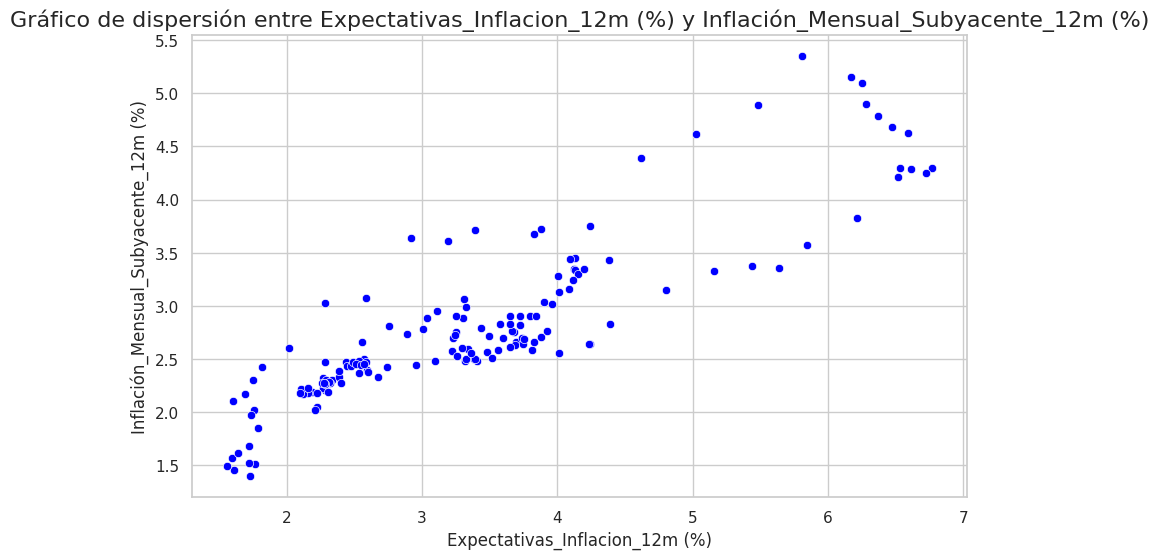

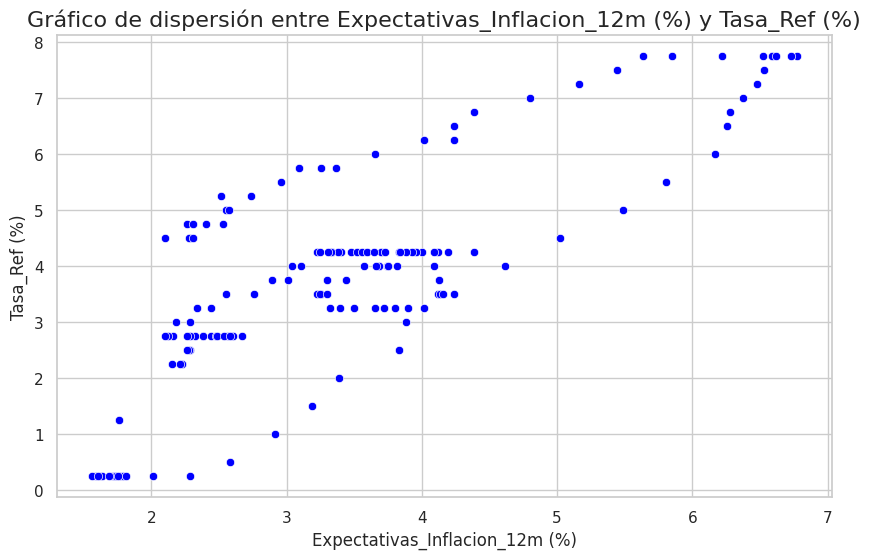

In [43]:
# Crear gráficos de dispersión para los pares con correlaciones más altas
pares_correlacionados = [
    ('Tasa_Ref (%)', 'Tasa_Interbancaria (%)'),
    ('CDBCR_Saldo_TIR (%)', 'Tasa_Ref (%)'),
    ('Tasa_Depositos_Overnight (%)', 'Tasa_Ref (%)'),
    ('Tasa_Interbancaria (%)', 'Tasa_Depositos_Overnight (%)'),
  ('Expectativas_Inflacion_12m (%)', 'Inflación_Mensual_Subyacente_12m (%)'),
    ('Expectativas_Inflacion_12m (%)', 'Tasa_Ref (%)'),

]

# Crear gráficos de dispersión para cada par
for var1, var2 in pares_correlacionados:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=df_bcrp[var1], y=df_bcrp[var2], color='blue')
    plt.title(f'Gráfico de dispersión entre {var1} y {var2}', fontsize=16)
    plt.xlabel(var1, fontsize=12)
    plt.ylabel(var2, fontsize=12)
    plt.grid(True)
    plt.show()


Los resultados confirman una correlación extremadamente alta entre la tasa de interés de referencia, la tasa interbancaria y la tasa de depósitos overnight, lo que refleja una transmisión efectiva y casi mecánica de la política monetaria del BCRP hacia las tasas de corto plazo del sistema financiero.

Asimismo, se observa una fuerte asociación entre la inflación subyacente interanual y las expectativas de inflación a 12 meses, lo que pone en evidencia el rol central del canal de expectativas en la dinámica inflacionaria de corto plazo. Esta relación refuerza la importancia de incorporar expectativas rezagadas en el enfoque de nowcasting.

La presencia de correlaciones elevadas entre varias tasas de interés y variables monetarias sugiere un alto grado de multicolinealidad, inherente al diseño y operación de la política monetaria moderna.

Desde una perspectiva de modelado predictivo, estas correlaciones elevadas anticipan la presencia de multicolinealidad entre las tasas de interés, lo que justifica el uso posterior de regularización (Ridge) y técnicas de reducción de dimensión (PCA) como herramientas complementarias, más que como sustitutos del enfoque estructural.

# **TG 2. Formulación del problema supervisado de nowcasting**


## **2.1. Reproducibilidad y entorno de trabajo**

Con el fin de garantizar la reproducibilidad de los resultados, se fija una semilla aleatoria común y se documentan las versiones de las principales librerías utilizadas.


In [44]:
# Importamos las librerías necesarias
warnings.filterwarnings('ignore')  # Ignora las advertencias para evitar mensajes innecesarios

RANDOM_STATE = 42           # Fijamos una semilla para reproducibilidad
np.random.seed(RANDOM_STATE)  # Establecemos la semilla aleatoria en NumPy


sns.set(style='whitegrid', context='talk')  # Configura el estilo visual de las gráficas


# Imprimimos las versiones de las librerías
print('numpy', np.__version__)
print('pandas', pd.__version__)
print('scikit-learn', sklearn.__version__)
print('statsmodels', statsmodels.__version__)




numpy 2.0.2
pandas 2.2.2
scikit-learn 1.6.1
statsmodels 0.14.6


## **2.2. Preparación del DataFrame para modelado**

En esta etapa se ajusta la estructura temporal del conjunto de datos para su uso en un contexto de predicción de series de tiempo. La variable de fecha se convierte a formato `datetime`, se ordena cronológicamente y se establece como índice del DataFrame.

Finalmente, se define un DataFrame de trabajo (`df`) que servirá como base para la construcción de rezagos, selección de variables y posterior formulación del problema supervisado.


In [45]:
# Asegurar que la columna Fecha esté en formato datetime
df_bcrp['Fecha'] = pd.to_datetime(df_bcrp['Fecha'], errors='coerce')

# Ordenar por la fecha
df_bcrp = df_bcrp.sort_values('Fecha').reset_index(drop=True)

# Colocar Fecha como índice
df_bcrp.set_index('Fecha', inplace=True)

# Renombrar df_bcrp como df para trabajar en los gráficos
df = df_bcrp.copy()

print('Dimensiones del df:', df.shape)
df.head()


Dimensiones del df: (152, 10)


,Tasa_Ref (%),Tasa_Depositos_Overnight (%),Inflación_Mensual_Subyacente_12m (%),Expectativas_Inflacion_12m (%),CDBCR_Total_Saldo (S/ millones),CDBCR_Saldo_TIR (%),Repos_Valores (S/ millones),Depositos_Publicos_Saldo (S/ millones),Depositos_Overnight_BCR (S/ miles),Tasa_Interbancaria (%)
Fecha,,,,,,,,,,
2013-01-01,4.25,3.45,2.591667,3.338063,36762.4,4.053,0.0,0.0,367807.0,4.1518
2013-02-01,4.25,3.45,2.575000,3.221990,36200.2,4.030,0.0,0.0,47590.0,4.2008
2013-03-01,4.25,3.45,2.562500,3.477736,36034.7,3.960,0.0,0.0,201773.0,4.2404
2013-04-01,4.25,3.45,2.483333,3.404137,37175.0,3.970,0.0,0.0,122430.0,4.2005
2013-05-01,4.25,3.45,2.479167,3.318773,33493.0,3.860,0.0,0.0,23520.0,4.2542


## **2.3. Construcción del problema supervisado**

En esta sección se formula explícitamente el problema de nowcasting de la inflación subyacente como un problema de aprendizaje supervisado. La variable objetivo corresponde a la inflación subyacente interanual, mientras que el conjunto de variables explicativas incorpora persistencia inflacionaria, expectativas y postura de política monetaria.

La especificación del modelo se construye mediante rezagos temporales, respetando estrictamente la causalidad económica y la disponibilidad de información en tiempo real. En particular, se incluyen rezagos de la inflación para capturar su inercia, expectativas de inflación rezagadas como canal informativo, y rezagos contemporáneos y pasados de la tasa de referencia y de instrumentos monetarios relevantes.

Este enfoque permite estructurar un conjunto de datos consistente con un ejercicio de predicción fuera de muestra, evitando el uso de información futura y sentando las bases para la estimación y comparación de distintos modelos predictivos.


In [46]:
target_col = 'Inflación_Mensual_Subyacente_12m (%)'   # Variable objetivo
expect_col = 'Expectativas_Inflacion_12m (%)'          # Expectativas de inflación
tir_col = 'Tasa_Ref (%)'                               # Tasa de referencia
monetary_cols = ['CDBCR_Total_Saldo (S/ millones)', 'CDBCR_Saldo_TIR (%)', 'Depositos_Publicos_Saldo (S/ millones)']  # Variables monetarias

# Crear rezagos de la inflación (1 a 3 meses)
for lag in range(1,4):
    df[f'inflacion_12m_lag{lag}'] = df[target_col].shift(lag)

df['Expectativas_Inflacion_12m_lag1'] = df[expect_col].shift(1)   # Rezago 1 de expectativas

# Crear rezagos de la tasa de referencia (0 a 3 meses)
for lag in range(0,4):
    df[f'TIR_lag{lag}'] = df[tir_col].shift(lag)

# Crear rezago 1 para cada variable monetaria
for col in monetary_cols:
    df[f'{col}_lag1'] = df[col].shift(1)

# Lista de variables predictoras
features = ['inflacion_12m_lag1','inflacion_12m_lag2','inflacion_12m_lag3',
            'Expectativas_Inflacion_12m_lag1','TIR_lag0','TIR_lag1','TIR_lag2','TIR_lag3'] + [f'{c}_lag1' for c in monetary_cols]

# Verificar que todas las columnas necesarias existan
missing = [c for c in features + [target_col] if c not in df.columns]
if missing:
    raise ValueError('Faltan columnas: ' + ', '.join(missing))

# Crear dataset final para el modelo y eliminar filas con NaN
df_model = df[features + [target_col]].dropna().copy()

print('Observaciones para modelado:', df_model.shape)
df_model.head()   # Mostrar primeras filas del dataset del modelo


Observaciones para modelado: (149, 12)


,inflacion_12m_lag1,inflacion_12m_lag2,inflacion_12m_lag3,Expectativas_Inflacion_12m_lag1,TIR_lag0,TIR_lag1,TIR_lag2,TIR_lag3,CDBCR_Total_Saldo (S/ millones)_lag1,CDBCR_Saldo_TIR (%)_lag1,Depositos_Publicos_Saldo (S/ millones)_lag1,Inflación_Mensual_Subyacente_12m (%)
Fecha,,,,,,,,,,,,
2013-04-01,2.562500,2.575000,2.591667,3.477736,4.25,4.25,4.25,4.25,36034.7,3.96,0.0,2.483333
2013-05-01,2.483333,2.562500,2.575000,3.404137,4.25,4.25,4.25,4.25,37175.0,3.97,0.0,2.479167
2013-06-01,2.479167,2.483333,2.562500,3.318773,4.25,4.25,4.25,4.25,33493.0,3.86,0.0,2.500000
2013-07-01,2.500000,2.479167,2.483333,3.382053,4.25,4.25,4.25,4.25,33661.1,3.92,0.0,2.512500
2013-08-01,2.512500,2.500000,2.479167,3.517619,4.25,4.25,4.25,4.25,31610.9,3.91,0.0,2.583333


## **2.4. Separación temporal y validación**

Dado el carácter temporal del problema de nowcasting, la muestra se divide respetando estrictamente el orden cronológico de las observaciones. El conjunto de entrenamiento corresponde al primer 75 % de la serie, mientras que el 25 % final se reserva como conjunto de prueba para la evaluación fuera de muestra.

Esta estrategia evita el uso de información futura en el entrenamiento y permite evaluar el desempeño predictivo de los modelos en un entorno realista. Adicionalmente, se implementa un esquema de validación cruzada específico para series de tiempo, que preserva la secuencia temporal y permite una estimación más robusta del error de predicción durante el proceso de entrenamiento y selección de hiperparámetros.


In [47]:
n = len(df_model)                                     # Número total de observaciones
test_size = int(np.ceil(0.25 * n))                    # Tamaño del conjunto de prueba (25%)
train_size = n - test_size                            # Tamaño del conjunto de entrenamiento

train = df_model.iloc[:train_size].copy()             # Datos de entrenamiento
test = df_model.iloc[train_size:].copy()              # Datos de prueba

X_train = train[features]; y_train = train[target_col]  # Variables predictoras y objetivo (train)
X_test = test[features]; y_test = test[target_col]      # Variables predictoras y objetivo (test)

print('Train', X_train.shape, 'Test', X_test.shape)   # Mostrar tamaños de los conjuntos

tscv = TimeSeriesSplit(n_splits=5)                    # Validación cruzada para series temporales


Train (111, 11) Test (38, 11)


## **2.5. Modelos baseline**

Antes de estimar modelos econométricos o de machine learning, se construyen modelos baseline simples que sirven como punto de referencia para evaluar el desempeño predictivo. Estos modelos permiten verificar si las especificaciones más complejas aportan valor predictivo real más allá de reglas simples.

Se consideran dos baselines estándar en el análisis de series temporales: un modelo de media histórica, que ignora la dinámica temporal, y un modelo de persistencia, que utiliza el último valor observado de la inflación subyacente como predicción. Ambos proporcionan cotas mínimas de desempeño contra las cuales se compararán los modelos estimados posteriormente.


In [48]:
# Baseline mean
y_pred_base_mean = np.repeat(y_train.mean(), len(y_test))
mse_base_mean = mean_squared_error(y_test, y_pred_base_mean)
r2_base_mean = r2_score(y_test, y_pred_base_mean)
# Baseline persistence
y_pred_persistence = X_test['inflacion_12m_lag1'].values
mse_persistence = mean_squared_error(y_test, y_pred_persistence)
r2_persistence = r2_score(y_test, y_pred_persistence)
print('Baseline mean MSE:', mse_base_mean, 'R2:', r2_base_mean)
print('Baseline persistence MSE:', mse_persistence, 'R2:', r2_persistence)

Baseline mean MSE: 1.226592148295128 R2: -0.29006646247076673
Baseline persistence MSE: 0.024965620431286244 R2: 0.9737424459483593


Los resultados muestran que el baseline de media presenta un desempeño predictivo deficiente, con un R² negativo, lo que indica que no logra capturar la dinámica de la inflación subyacente.

En contraste, el baseline de persistencia exhibe un desempeño notablemente alto, reflejando la fuerte inercia que caracteriza a la inflación subyacente interanual en el Perú. Este resultado establece un umbral exigente para los modelos más sofisticados y sugiere que cualquier mejora predictiva deberá provenir de la incorporación de información adicional más allá de la simple persistencia.




# **TG 3. Modelado y evaluación predictiva**


## **3.1. Modelo lineal OLS como benchmark econométrico**

Como primer modelo estructural, se estima una regresión lineal por mínimos cuadrados ordinarios (OLS), que sirve como benchmark econométrico para evaluar el aporte predictivo de las variables incluidas.

El modelo incorpora rezagos de la inflación subyacente, expectativas de inflación y variables de política monetaria, permitiendo analizar tanto su capacidad predictiva fuera de muestra como la coherencia económica de los coeficientes estimados. A diferencia de los baselines, este enfoque permite evaluar explícitamente la contribución marginal de cada variable al proceso inflacionario.


In [49]:
X_tr_sm = sm.add_constant(X_train)               # Agrega constante (intercepto) al modelo
ols_final = sm.OLS(y_train, X_tr_sm).fit()       # Ajusta un modelo OLS (mínimos cuadrados)
display(ols_final.summary())                     # Muestra el resumen del modelo

y_pred_ols = ols_final.predict(sm.add_constant(X_test))   # Predicciones sobre el conjunto de prueba

mse_ols_test = mean_squared_error(y_test, y_pred_ols)     # Error cuadrático medio en test
r2_ols_test = r2_score(y_test, y_pred_ols)                # R2 en test

print('OLS Test MSE: {:.6f}, R2: {:.6f}'.format(mse_ols_test, r2_ols_test))   # Métricas del modelo


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     OLS Regression Results                                     
================================================================================================
Dep. Variable:     Inflación_Mensual_Subyacente_12m (%)   R-squared:                       0.972
Model:                                              OLS   Adj. R-squared:                  0.969
Method:                                   Least Squares   F-statistic:                     316.1
Date:                                  Wed, 17 Dec 2025   Prob (F-statistic):           7.05e-72
Time:                                          14:54:03   Log-Likelihood:                 87.890
No. Observations:                                   111   AIC:                            -151.8
Df Residuals:                                        99   BIC:                            -119.3
Df Model:                                            11                                         
Covariance Type:                              nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                          -0.0639      0.123     -0.517      0.606      -0.309       0.181
inflacion_12m_lag1                              0.9865      0.100      9.817      0.000       0.787       1.186
inflacion_12m_lag2                              0.1496      0.142      1.055      0.294      -0.132       0.431
inflacion_12m_lag3                             -0.2638      0.103     -2.567      0.012      -0.468      -0.060
Expectativas_Inflacion_12m_lag1                 0.1039      0.039      2.653      0.009       0.026       0.182
TIR_lag0                                        0.2141      0.074      2.875      0.005       0.066       0.362
TIR_lag1                                       -0.1171      0.125     -0.933      0.353      -0.366       0.132
TIR_lag2                                       -0.1707      0.128     -1.335      0.185      -0.425       0.083
TIR_lag3                                        0.0659      0.084      0.781      0.437      -0.102       0.233
CDBCR_Total_Saldo (S/ millones)_lag1         2.832e-06   1.39e-06      2.035      0.045    7.09e-08    5.59e-06
CDBCR_Saldo_TIR (%)_lag1                        0.0044      0.047      0.094      0.925      -0.088       0.097
Depositos_Publicos_Saldo (S/ millones)_lag1  1.033e-05   9.06e-06      1.141      0.257   -7.64e-06    2.83e-05
==============================================================================
Omnibus:                       19.154   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.041
Skew:                           0.792   Prob(JB):                     3.00e-07
Kurtosis:                       4.996   Cond. No.                     6.42e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.42e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

OLS Test MSE: 0.058149, R2: 0.938842


Los resultados confirman que la inflación subyacente presenta una elevada persistencia, reflejada en el coeficiente cercano a la unidad del primer rezago, lo que es consistente con la evidencia empírica para economías con esquemas de metas de inflación creíbles.

Las expectativas de inflación rezagadas resultan estadísticamente significativas y con signo positivo, lo que respalda el rol central del canal de expectativas en la dinámica inflacionaria de corto plazo. Asimismo, el coeficiente positivo y significativo de la tasa de referencia contemporánea sugiere que la política monetaria responde de manera sistemática a presiones inflacionarias, reflejando la función de reacción del banco central más que un efecto causal inmediato.

Desde el punto de vista predictivo, el modelo OLS logra un buen desempeño fuera de muestra, aunque no supera al baseline de persistencia. Este resultado es consistente con la alta inercia de la inflación subyacente y establece un punto de referencia exigente para modelos alternativos que incorporen regularización o no linealidades.


## **3.2. Diagnóstico de residuos y robustez de la estimación**

Luego de estimar el modelo OLS, se realizan pruebas de diagnóstico sobre los residuos con el objetivo de evaluar la presencia de heterocedasticidad y autocorrelación, fenómenos frecuentes en series macroeconómicas.

Dado que estas características pueden afectar la validez de la inferencia estadística, se complementa el análisis con una estimación de errores robustos de tipo Newey–West, manteniendo inalterados los coeficientes del modelo.


In [50]:
# Test de heterocedasticidad y autocorrelación

bp = het_breuschpagan(ols_final.resid, ols_final.model.exog)
labels = ['LM Stat', 'LM pvalue', 'F Stat', 'F pvalue']
print('Breusch–Pagan:', dict(zip(labels, bp)))
print('Durbin–Watson:', durbin_watson(ols_final.resid))

# Estimación con errores robustos Newey–West (HAC)
ols_nw = ols_final.get_robustcov_results(cov_type='HAC', maxlags=4)
print("\n--- OLS con errores robustos Newey–West ---")
display(ols_nw.summary())


Breusch–Pagan: {'LM Stat': np.float64(24.380998819841718), 'LM pvalue': np.float64(0.011219146566648172), 'F Stat': np.float64(2.5332662162911173), 'F pvalue': np.float64(0.007353254278300434)}
Durbin–Watson: 1.9173720017618188

--- OLS con errores robustos Newey–West ---


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     OLS Regression Results                                     
================================================================================================
Dep. Variable:     Inflación_Mensual_Subyacente_12m (%)   R-squared:                       0.972
Model:                                              OLS   Adj. R-squared:                  0.969
Method:                                   Least Squares   F-statistic:                     395.7
Date:                                  Wed, 17 Dec 2025   Prob (F-statistic):           1.41e-76
Time:                                          14:54:03   Log-Likelihood:                 87.890
No. Observations:                                   111   AIC:                            -151.8
Df Residuals:                                        99   BIC:                            -119.3
Df Model:                                            11                                         
Covariance Type:                                    HAC                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                          -0.0639      0.143     -0.447      0.656      -0.348       0.220
inflacion_12m_lag1                              0.9865      0.096     10.321      0.000       0.797       1.176
inflacion_12m_lag2                              0.1496      0.156      0.959      0.340      -0.160       0.459
inflacion_12m_lag3                             -0.2638      0.111     -2.383      0.019      -0.483      -0.044
Expectativas_Inflacion_12m_lag1                 0.1039      0.041      2.520      0.013       0.022       0.186
TIR_lag0                                        0.2141      0.074      2.879      0.005       0.067       0.362
TIR_lag1                                       -0.1171      0.127     -0.922      0.359      -0.369       0.135
TIR_lag2                                       -0.1707      0.101     -1.693      0.094      -0.371       0.029
TIR_lag3                                        0.0659      0.078      0.848      0.398      -0.088       0.220
CDBCR_Total_Saldo (S/ millones)_lag1         2.832e-06    1.7e-06      1.669      0.098   -5.35e-07     6.2e-06
CDBCR_Saldo_TIR (%)_lag1                        0.0044      0.037      0.118      0.906      -0.069       0.078
Depositos_Publicos_Saldo (S/ millones)_lag1  1.033e-05   8.61e-06      1.200      0.233   -6.76e-06    2.74e-05
==============================================================================
Omnibus:                       19.154   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.041
Skew:                           0.792   Prob(JB):                     3.00e-07
Kurtosis:                       4.996   Cond. No.                     6.42e+05
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 4 lags and without small sample correction
[2] The condition number is large, 6.42e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Los resultados del test de Breusch–Pagan sugieren la presencia de heterocedasticidad en los residuos, un resultado consistente con episodios de mayor volatilidad asociados a shocks externos a lo largo del período de análisis. No obstante, el estadístico de Durbin–Watson, cercano a 2, indica ausencia de autocorrelación residual relevante.

La estimación con errores robustos de Newey–West confirma que la magnitud, el signo y la significancia de los coeficientes se mantienen estables, lo que refuerza la validez del modelo para fines de predicción. En términos prácticos, esto sugiere que las desviaciones residuales responden principalmente a factores transitorios o exógenos, más que a una especificación inadecuada del modelo.


## **3.3. Multicolinealidad y reducción de dimensión**

Dado el elevado número de rezagos y la naturaleza altamente persistente de las variables monetarias, se evalúa la presencia de multicolinealidad mediante el factor de inflación de la varianza (VIF).

Asimismo, se aplica un Análisis de Componentes Principales (PCA) sobre el subconjunto de variables monetarias, con el objetivo de explorar si la información común puede resumirse en un número reducido de factores y evaluar su potencial uso en modelos predictivos posteriores.


,var,VIF
7,TIR_lag2,241.808269
6,TIR_lag1,235.601148
0,const,125.620379
8,TIR_lag3,104.956679
5,TIR_lag0,84.984366
2,inflacion_12m_lag2,54.011341
1,inflacion_12m_lag1,30.789537
10,CDBCR_Saldo_TIR (%)_lag1,29.384236
3,inflacion_12m_lag3,25.260734
4,Expectativas_Inflacion_12m_lag1,9.642051


Varianza explicada (PC1, PC2): [0.80730268 0.13526325]


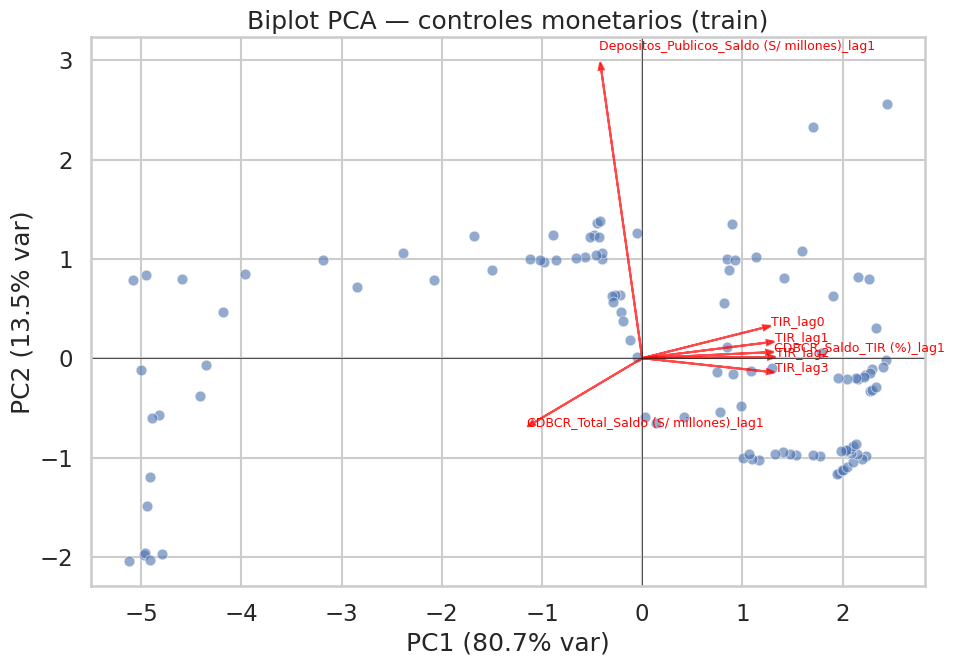

In [51]:


X_vif = sm.add_constant(X_train)   # Agrega constante para el cálculo de VIF
vif = pd.DataFrame({
    'var': X_vif.columns,
    'VIF': [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})                                   # Calcula el VIF de cada variable
vif = vif.sort_values('VIF', ascending=False)   # Ordena de mayor a menor multicolinealidad
display(vif)                         # Muestra tabla de VIF

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

monetary_features = [f'{c}_lag1' for c in monetary_cols] + [f'TIR_lag{i}' for i in range(4)]
X_monetary = X_train[monetary_features].dropna()     # Selecciona solo las variables monetarias

scaler_pca = StandardScaler().fit(X_monetary)        # Estandariza datos (PCA requiere escalado)
X_m_s = scaler_pca.transform(X_monetary)

pca = PCA(n_components=2).fit(X_m_s)                 # Ajusta PCA con 2 componentes principales
pc_scores = pca.transform(X_m_s)                     # Obtiene coordenadas en el espacio PCA
print('Varianza explicada (PC1, PC2):', pca.explained_variance_ratio_)

plt.figure(figsize=(10,7))
sns.scatterplot(x=pc_scores[:,0], y=pc_scores[:,1], alpha=0.6, s=60)   # Gráfico de dispersión en espacio PCA
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)')
plt.title('Biplot PCA — controles monetarios (train)')

loadings = pca.components_.T   # Cargas de cada variable en los PCs
for i, varname in enumerate(monetary_features):
    plt.arrow(0, 0, loadings[i,0]*3, loadings[i,1]*3, color='red', alpha=0.7, head_width=0.05)  # Vectores de carga
    plt.text(loadings[i,0]*3.2, loadings[i,1]*3.2, varname, color='red', fontsize=9)             # Etiquetas
plt.axhline(0, color='k', linewidth=0.5); plt.axvline(0, color='k', linewidth=0.5)               # Ejes centrales

plt.tight_layout()
plt.show()     # Muestra el biplot

El análisis de multicolinealidad muestra que los distintos rezagos de la tasa de referencia del BCRP presentan valores VIF muy elevados, lo que evidencia una fuerte correlación entre ellos. Este resultado no refleja un problema de especificación, sino una característica inherente al diseño de la política monetaria: los ajustes de la tasa de referencia se realizan de manera gradual, generando una elevada persistencia temporal.

El PCA aplicado a las variables monetarias confirma esta estructura, ya que el primer componente principal explica más del 80 % de la varianza total y puede interpretarse como un factor común asociado a la postura general de la política monetaria. Esto sugiere que los distintos instrumentos del BCRP se mueven de forma coordinada.

Sin embargo, la capacidad de los componentes principales para resumir la varianza no implica necesariamente una mejora en la predicción. Como se mostrará en la sección 3.4, al utilizar estos componentes en modelos predictivos, el desempeño fuera de muestra se deteriora, lo que indica que la reducción de dimensión elimina parte de la señal temporal relevante para anticipar la inflación subyacente.


### **3.3.1. Interpretación de las cargas del PCA monetario**

Con el fin de interpretar económicamente los componentes principales obtenidos, se analizan las cargas (loadings) asociadas a cada variable monetaria. Este ejercicio permite identificar qué instrumentos explican la mayor parte de la varianza común y clarificar el significado económico de cada componente.


In [52]:
# Loadings del PCA monetario
loadings_monetary = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=monetary_features
)

print("Loadings del PCA monetario:")
display(loadings_monetary)


Loadings del PCA monetario:


,PC1,PC2
CDBCR_Total_Saldo (S/ millones)_lag1,-0.360483,-0.216427
CDBCR_Saldo_TIR (%)_lag1,0.412134,0.019524
Depositos_Publicos_Saldo (S/ millones)_lag1,-0.136242,0.968273
TIR_lag0,0.403194,0.102279
TIR_lag1,0.414514,0.052360
TIR_lag2,0.418494,0.003621
TIR_lag3,0.414862,-0.044841


Los loadings del PCA monetario muestran una estructura clara y coherente con el diseño operativo de la política monetaria del BCRP.

El primer componente principal (PC1) presenta cargas elevadas y homogéneas en los cuatro rezagos de la tasa de referencia, así como en la tasa de los CDBCR. Esto indica que PC1 captura un factor de postura monetaria estructural, asociado a movimientos persistentes y coordinados de la política monetaria. La alineación de todos los rezagos de la TIR refleja la gradualidad y previsibilidad con la que el BCRP ajusta su tasa de política.

Las cargas negativas moderadas de los saldos monetarios sugieren que, ante aumentos en la tasa de referencia, la liquidez neta del sistema tiende a ajustarse en sentido opuesto, como parte del mecanismo operativo para estabilizar las tasas de corto plazo.

El segundo componente (PC2), en cambio, está dominado casi exclusivamente por los depósitos públicos, lo que indica que este factor recoge variaciones específicas y episódicas en la gestión de liquidez del sector público, relativamente desacopladas de la postura monetaria general.

En conjunto, el PCA revela la existencia de un factor monetario común muy fuerte (PC1), consistente con la coordinación entre la tasa de referencia y los instrumentos del BCRP, mientras que PC2 captura ajustes idiosincráticos de liquidez.



## **3.4. PCA extendido: expectativas y variables monetarias del BCRP**

En esta sección se amplía el análisis de componentes principales para incluir, además de los instrumentos monetarios del BCRP, las expectativas de inflación a 12 meses. El objetivo es identificar factores latentes comunes que resuman la dinámica conjunta entre política monetaria y expectativas, y evaluar si estos factores aportan capacidad explicativa adicional sobre la inflación subyacente en un entorno de pronóstico.

Se extraen dos componentes principales, se analiza su estructura mediante un biplot y posteriormente se utilizan como predictores en un modelo OLS, comparando el desempeño fuera de muestra con las especificaciones basadas en variables observables.


Varianza explicada por PC1 y PC2: 56.01% + 27.40% = 83.41%


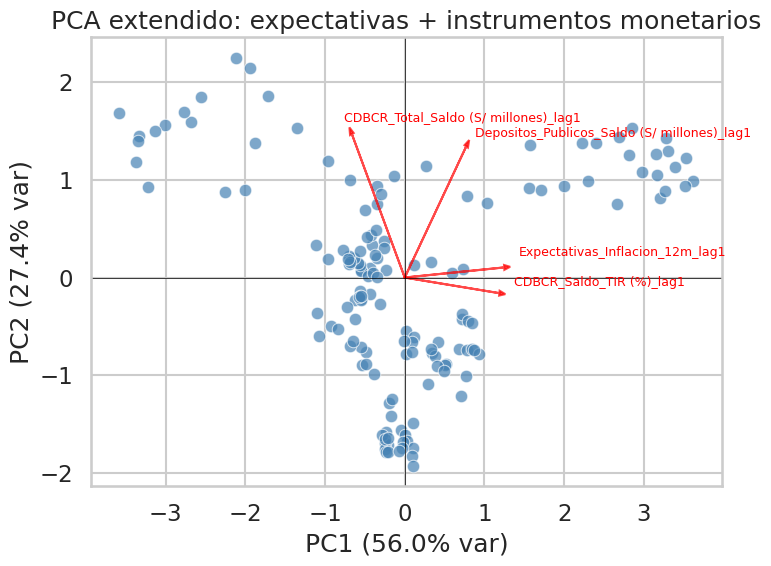

OLS con PCA — MSE test: 1.303175, R² test: -0.370613


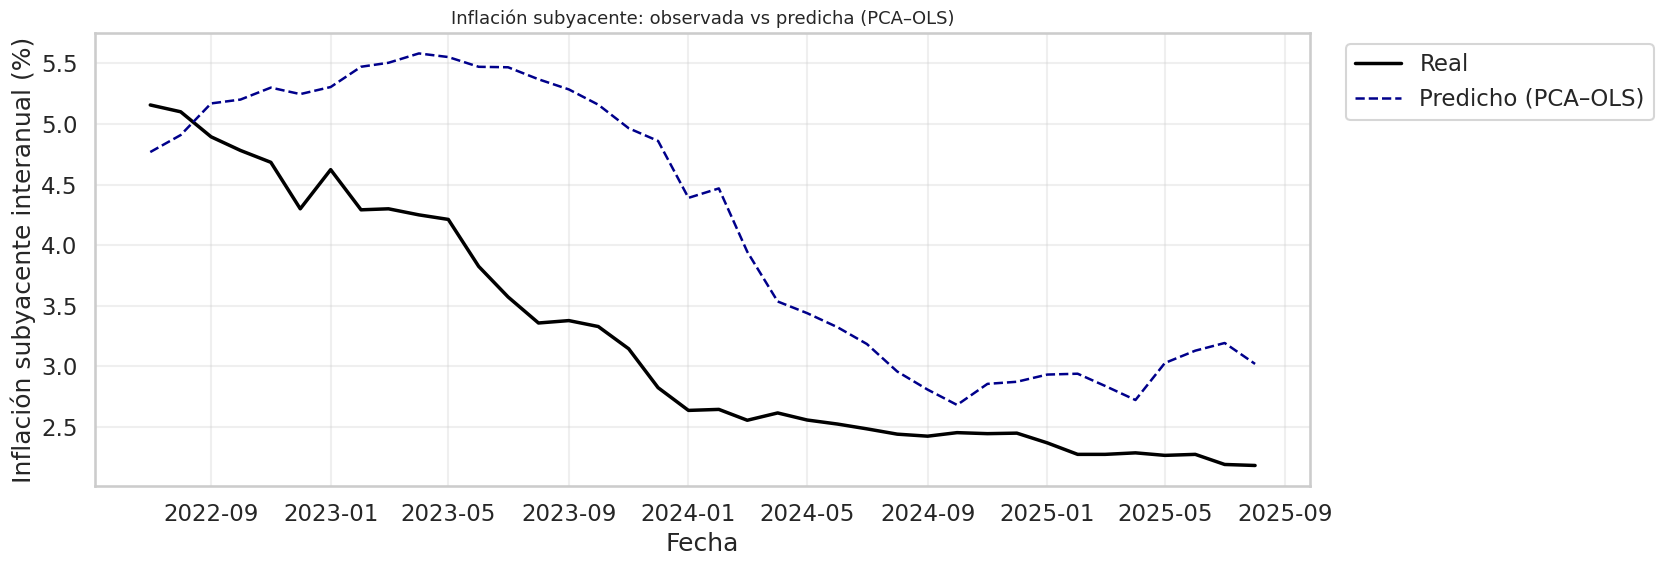

In [53]:
# ============================================================
#  PCA extendido: expectativas y variables monetarias del BCRP
# ============================================================

# Variables incluidas en el PCA: expectativas + instrumentos del BCRP
pca_vars = [
    'Expectativas_Inflacion_12m_lag1',
    'CDBCR_Total_Saldo (S/ millones)_lag1',
    'CDBCR_Saldo_TIR (%)_lag1',
    'Depositos_Publicos_Saldo (S/ millones)_lag1'
]

# Escalamiento estándar (PCA requiere estandarización)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_model[pca_vars])

# PCA con dos componentes principales
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Varianza explicada
explained = pca.explained_variance_ratio_
print(f"Varianza explicada por PC1 y PC2: {explained[0]*100:.2f}% + "
      f"{explained[1]*100:.2f}% = {explained.sum()*100:.2f}%")

# DataFrame con los componentes principales
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'], index=df_model.index)

# ------------------------------------------------------------
# Biplot PCA extendido
# ------------------------------------------------------------
plt.figure(figsize=(8,6))
sns.scatterplot(x='PC1', y='PC2', data=pca_df, alpha=0.7, color='steelblue')

plt.xlabel(f'PC1 ({explained[0]*100:.1f}% var)')
plt.ylabel(f'PC2 ({explained[1]*100:.1f}% var)')
plt.title('PCA extendido: expectativas + instrumentos monetarios')

# Flechas de carga
loadings = pca.components_.T
for i, varname in enumerate(pca_vars):
    x, y = loadings[i,0]*2, loadings[i,1]*2
    plt.arrow(0, 0, x, y, color='red', alpha=0.7, head_width=0.05)

    offset_y = 0.10 if i % 2 == 0 else -0.10
    plt.text(x*1.15, y*1.15 + offset_y, varname, color='red', fontsize=9)

plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.tight_layout()
plt.show()

# ============================================================
#  Evaluación predictiva SOLO con OLS (PC1 y PC2)
# ============================================================


from sklearn.metrics import mean_squared_error, r2_score

# División temporal coherente con el train/test original
X_train_pca = pca_df.iloc[:train_size]
X_test_pca = pca_df.iloc[train_size:]

y_train_pca = y_train
y_test_pca = y_test

# OLS usando los dos componentes principales
X_train_pca_ols = sm.add_constant(X_train_pca)
X_test_pca_ols = sm.add_constant(X_test_pca)

ols_pca_model = sm.OLS(y_train_pca, X_train_pca_ols).fit()

# Predicciones
y_pred_pca_ols = ols_pca_model.predict(X_test_pca_ols)

# Métricas
mse_pca_ols = mean_squared_error(y_test_pca, y_pred_pca_ols)
r2_pca_ols = r2_score(y_test_pca, y_pred_pca_ols)

print(f'OLS con PCA — MSE test: {mse_pca_ols:.6f}, R² test: {r2_pca_ols:.6f}')

# ============================================================
# Gráfico Real vs. Predicho (PCA–OLS)
# ============================================================

df_pca_pred_ols = pd.DataFrame({
    'Real': y_test_pca,
    'Predicho (PCA–OLS)': y_pred_pca_ols
}, index=y_test_pca.index)

plt.figure(figsize=(17,6))
sns.lineplot(data=df_pca_pred_ols['Real'], label='Real', color='black', linewidth=2.5)
sns.lineplot(data=df_pca_pred_ols['Predicho (PCA–OLS)'],
             label='Predicho (PCA–OLS)',
             color='darkblue', linewidth=1.8, linestyle='--')

plt.title('Inflación subyacente: observada vs predicha (PCA–OLS)', fontsize=13)
plt.ylabel('Inflación subyacente interanual (%)')
plt.xlabel('Fecha')
plt.grid(alpha=0.3)
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.show()


Al ampliar el PCA para incluir las expectativas de inflación junto con los instrumentos monetarios del BCRP, los dos primeros componentes explican aproximadamente el 83 % de la varianza total, lo que revela una estructura conjunta bien definida entre política monetaria y percepciones del mercado.

El primer componente puede interpretarse como un factor de postura monetaria y condiciones de liquidez, mientras que el segundo captura principalmente la respuesta de las expectativas frente a cambios en el entorno monetario. Desde una perspectiva económica, esta configuración sugiere que las expectativas reaccionan de manera ordenada y sistemática a las señales emitidas por el BCRP, lo que es consistente con un esquema de política monetaria creíble.

Sin embargo, al utilizar estos componentes como predictores en un modelo OLS, el desempeño fuera de muestra se deteriora de forma significativa, con un R² negativo y un error sustancialmente mayor que los baselines de persistencia. El gráfico de inflación observada versus predicha muestra que el modelo PCA–OLS genera trayectorias excesivamente suaves y tiende a sobreestimar la inflación de manera persistente, lo que indica una pérdida de información relevante de corto plazo.

Este resultado confirma que, si bien el PCA es útil para resumir estructuras latentes y facilitar la interpretación económica, la compresión de la información elimina señales temporales clave necesarias para la predicción de la inflación subyacente. En consecuencia, el uso de componentes principales no mejora —e incluso perjudica— el desempeño predictivo frente a modelos que explotan directamente la dinámica temporal de las variables observadas.


### **3.4.1. Interpretación de las cargas del PCA extendido**

In [54]:
# Loadings del PCA extendido
loadings_extended = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=pca_vars
)

print("Loadings del PCA extendido:")
display(loadings_extended)


Loadings del PCA extendido:


,PC1,PC2
Expectativas_Inflacion_12m_lag1,0.623821,0.051800
CDBCR_Total_Saldo (S/ millones)_lag1,-0.331559,0.734849
CDBCR_Saldo_TIR (%)_lag1,0.593544,-0.080089
Depositos_Publicos_Saldo (S/ millones)_lag1,0.385513,0.671490


Al incorporar las expectativas de inflación junto con los instrumentos monetarios del BCRP, el PCA extendido identifica dos factores bien diferenciados.

El **primer componente (PC1)** presenta cargas elevadas tanto en las expectativas de inflación como en variables monetarias asociadas a la tasa de interés y a la absorción de liquidez. Esto indica que PC1 captura un **factor macro–monetario agregado**, en el que la postura de política monetaria y la formación de expectativas se mueven de manera coordinada. Este resultado es consistente con el canal de expectativas del régimen de metas de inflación, donde las señales del banco central influyen directamente en las percepciones del mercado.

El **segundo componente (PC2)** está dominado por variables de liquidez del sistema financiero, particularmente el saldo total de CDBCR y los depósitos públicos, mientras que las expectativas prácticamente no cargan en este factor. Esto sugiere que PC2 recoge **ajustes operativos e idiosincráticos de liquidez**, que no necesariamente tienen un impacto directo sobre la inflación esperada.

En conjunto, el PCA extendido muestra que existe un fuerte factor común entre expectativas y política monetaria, pero también revela movimientos de liquidez más tácticos que el modelo separa como un componente independiente.



## **3.5. Ridge Regression — regularización y estabilidad predictiva**

Luego de establecer el modelo OLS como benchmark econométrico (Sección 3.1) y diagnosticar la presencia de multicolinealidad estructural entre los rezagos de la tasa de referencia y otros instrumentos monetarios (Sección 3.3), esta sección introduce Ridge Regression como una extensión natural orientada a la estabilidad predictiva.

Desde un punto de vista econométrico, la multicolinealidad observada no constituye un problema conceptual —es consistente con la gradualidad de la política monetaria del BCRP—, pero sí puede generar: coeficientes inestables,
sensibilidad excesiva a pequeñas perturbaciones en los datos, y menor robustez fuera de muestra.

Ridge Regression aborda este problema incorporando un término de penalización $α^2$ que suaviza los coeficientes, reduciendo la varianza del estimador sin imponer selección discreta de variables.

#### ****Enfoque metodológico:****

Se implementan dos estrategias complementarias para la selección del parámetro de regularización α:

- GridSearchCV, que realiza una búsqueda exhaustiva en un rango logarítmico amplio, utilizando validación cruzada específica para series de tiempo.

- RidgeCV, que aplica una validación cruzada interna más compacta y computacionalmente eficiente.

Ambos enfoques permiten evaluar si la regularización mejora la capacidad predictiva respecto al OLS, sin sacrificar interpretabilidad económica.

In [55]:

# Pipeline: estandariza los datos y luego aplica Ridge
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(random_state=RANDOM_STATE))
])

# Búsqueda de alpha en un rango amplio logarítmico
param_grid = {'ridge__alpha': np.logspace(-4, 4, 40)}

# GridSearchCV con validación cruzada para series temporales
g_ridge = GridSearchCV(pipe, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
g_ridge.fit(X_train, y_train)

best_alpha_grid = g_ridge.best_params_['ridge__alpha']   # Mejor alpha encontrado
print('GridSearch Ridge best alpha:', best_alpha_grid, 'CV MSE:', -g_ridge.best_score_)

# RidgeCV: validación cruzada interna del propio Ridge
alphas = np.logspace(-4, 4, 40)
ridge_cv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error', cv=tscv).fit(X_train, y_train)
print('RidgeCV alpha:', ridge_cv.alpha_)

# Predicciones del mejor modelo encontrado en GridSearch
best_ridge = g_ridge.best_estimator_
y_pred_ridge = best_ridge.predict(X_test)

mse_ridge_test = mean_squared_error(y_test, y_pred_ridge)   # Métricas en test
r2_ridge_test = r2_score(y_test, y_pred_ridge)
print('Ridge (Grid) Test MSE:', mse_ridge_test, 'R2:', r2_ridge_test)

# Predicciones usando RidgeCV
y_pred_ridgecv = ridge_cv.predict(X_test)
print('RidgeCV Test MSE:', mean_squared_error(y_test, y_pred_ridgecv),
      'R2:', r2_score(y_test, y_pred_ridgecv))


GridSearch Ridge best alpha: 0.30702906297578497 CV MSE: 0.055322953076583824
RidgeCV alpha: 0.0001
Ridge (Grid) Test MSE: 0.06248690303657869 R2: 0.9342794929323509
RidgeCV Test MSE: 0.058152245347228806 R2: 0.9388384626918539


Ambos métodos convergen hacia valores de regularización muy pequeños (α ≈ 0.3 en GridSearchCV y α ≈ 0.0001 en RidgeCV). La convergencia de α cercano a cero indica que:

- El modelo lineal está bien especificado:
la información relevante para predecir la inflación subyacente ya está contenida en los rezagos de inflación, expectativas y tasa de referencia.

- La multicolinealidad detectada es estructural, no patológica:
responde a la persistencia inherente de la política monetaria, y no a un problema de sobreajuste o redundancia irrelevante.

- La regularización cumple un rol de validación, más que de corrección:
Ridge confirma que los coeficientes estimados por OLS son estables y que no dependen críticamente de combinaciones específicas de variables altamente correlacionadas.

Desde un punto de vista económico, Ridge actúa como un filtro de robustez: suaviza la sensibilidad del modelo ante pequeñas variaciones en los instrumentos monetarios, sin alterar la relación fundamental entre inflación, expectativas y política monetaria.

**GridSearchCV vs. RidgeCV**

* GridSearchCV ofrece mayor control y transparencia sobre el proceso de selección de α, siendo preferible cuando se busca documentación detallada del ajuste.

* RidgeCV resulta más compacto y reproducible, adecuado como verificación rápida de robustez.

La consistencia entre ambos métodos refuerza la confiabilidad de los resultados y posiciona a Ridge como un puente natural entre la inferencia econométrica clásica y el enfoque predictivo de machine learning.


## **3.6. Modelos no lineales: Random Forest y XGBoost**

Hasta este punto, el análisis ha mostrado que modelos lineales bien especificados (OLS y Ridge) capturan de manera eficiente la dinámica de corto plazo de la inflación subyacente, dominada por persistencia, expectativas y la tasa de referencia. Sin embargo, es relevante evaluar si **relaciones no lineales o interacciones complejas** entre estas variables pueden aportar mejoras adicionales en capacidad predictiva.

Con este objetivo, se incorporan dos modelos no lineales ampliamente utilizados en nowcasting macroeconómico: **Random Forest** y **XGBoost**. Ambos modelos permiten:
- capturar interacciones no aditivas,
- manejar efectos umbral y asimetrías,
- y reducir supuestos funcionales sobre la relación entre predictores y la inflación.

#### Validación estrictamente temporal (GAP + horizonte)

Dado que el conjunto de predictores incluye rezagos de la inflación, expectativas y variables monetarias, la validación se diseña cuidadosamente para **evitar fugas de información**:

- Se detecta automáticamente el **rezago máximo utilizado (MAX_LAG = 3)**.
- Se introduce un **GAP temporal igual a MAX_LAG**, garantizando que las observaciones usadas para entrenar no contengan información solapada con el período de validación.
- Se define un **horizonte de validación (HORIZON = 21 meses)**, que representa el mayor tamaño posible compatible con cinco divisiones temporales (`TimeSeriesSplit`).

Este esquema aproxima de forma realista el entorno de predicción fuera de muestra y reduce el riesgo de sobreajuste, especialmente relevante en modelos de alta flexibilidad.

#### Optimización de hiperparámetros

Debido al amplio espacio de hiperparámetros de ambos modelos, se utiliza **RandomizedSearchCV**, que permite explorar configuraciones profundas y flexibles de manera computacionalmente eficiente, manteniendo coherencia temporal en la validación.


In [56]:
# ============================================================
#  9. Modelos no lineales con RandomizedSearchCV + GAP temporal
# ============================================================

# ============================================================
#  DETECCIÓN AUTOMÁTICA DEL REZAGO MÁXIMO (MAX_LAG)
# ============================================================

# Detecta automáticamente el mayor rezago usado en las columnas
MAX_LAG = max(
    int(col.split('lag')[-1])
    for col in X_train.columns
    if 'lag' in col
)

HORIZON = 21   # 21 es lo máximo, con 22 sale error

print(f"MAX_LAG detectado automáticamente: {MAX_LAG}")
print(f"HORIZON: {HORIZON}")

# Nuevo esquema de validación temporal con GAP + HORIZON
tscv = TimeSeriesSplit(
    n_splits=5,
    gap=MAX_LAG,
    test_size=HORIZON
)

print(tscv)


# ============================================================
#  VERIFICACIÓN DE IMPORTACIÓN DE XGBoost
# ============================================================

try:
    from xgboost import XGBRegressor
    from xgboost import __version__ as xgb_version
    print(f"XGBoost cargado correctamente. Versión: {xgb_version}")
    xgb_available = True
except Exception as e:
    print("XGBoost NO se pudo importar. Se usará GradientBoostingRegressor.")
    print("Detalle del error:", e)
    from sklearn.ensemble import GradientBoostingRegressor as XGBRegressor
    xgb_available = False



# ============================================================
#        RANDOM FOREST (RandomizedSearchCV)
# ============================================================

rf = RandomForestRegressor(random_state=RANDOM_STATE)

param_dist_rf = {
    'n_estimators': [300, 400, 500, 700],
    'max_depth': [3, 5, 7, 10, 15, None],
    'max_features': ['sqrt', 'log2', 'auto', 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_leaf_nodes': [None, 20, 50, 100]
}

g_rf = RandomizedSearchCV(
    rf,
    param_dist_rf,
    n_iter=40,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

g_rf.fit(X_train, y_train)

print("\n---- Random Forest ----")
print("RF best params:", g_rf.best_params_)
print("RF best CV MSE:", -g_rf.best_score_)

best_rf = g_rf.best_estimator_

y_pred_rf = best_rf.predict(X_test)
mse_rf_test = mean_squared_error(y_test, y_pred_rf)
r2_rf_test = r2_score(y_test, y_pred_rf)

print("RF Test MSE:", mse_rf_test, "R2:", r2_rf_test)



# ============================================================
#            XGBOOST (RandomizedSearchCV más estable)
# ============================================================

xgb = XGBRegressor(random_state=RANDOM_STATE)

param_dist_xgb = {
    'n_estimators': [300, 500, 800],
    'learning_rate': [0.01, 0.03, 0.05],
    'max_depth': [2, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.1, 0.3],
    'reg_lambda': [1, 5, 10]
}

g_xgb = RandomizedSearchCV(
    xgb,
    param_dist_xgb,
    n_iter=50,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

g_xgb.fit(X_train, y_train)

print("\n---- XGBoost ----")
print("XGB best params:", g_xgb.best_params_)
print("XGB best CV MSE:", -g_xgb.best_score_)

best_xgb = g_xgb.best_estimator_

y_pred_xgb = best_xgb.predict(X_test)
mse_xgb_test = mean_squared_error(y_test, y_pred_xgb)
r2_xgb_test = r2_score(y_test, y_pred_xgb)

print("XGB Test MSE:", mse_xgb_test, "R2:", r2_xgb_test)


MAX_LAG detectado automáticamente: 3
HORIZON: 21
TimeSeriesSplit(gap=3, max_train_size=None, n_splits=5, test_size=21)
XGBoost cargado correctamente. Versión: 3.1.2

---- Random Forest ----
RF best params: {'n_estimators': 700, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_leaf_nodes': None, 'max_features': 10, 'max_depth': 15}
RF best CV MSE: 0.23828534602132195
RF Test MSE: 0.1489692314271752 R2: 0.8433218330385034

---- XGBoost ----
XGB best params: {'subsample': 1.0, 'reg_lambda': 5, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 1.0}
XGB best CV MSE: 0.24836348938988814
XGB Test MSE: 0.08908409154749088 R2: 0.906305939586496


Los resultados confirman diferencias claras entre los modelos no lineales evaluados:

- **Random Forest** alcanza un desempeño moderado fuera de muestra  
  (MSE ≈ 0.15, R² ≈ 0.84), mejorando a los baselines simples pero sin superar a los modelos lineales.

- **XGBoost** muestra un desempeño superior dentro del conjunto de modelos no lineales  
  (MSE ≈ 0.089, R² ≈ 0.91), evidenciando su capacidad para capturar interacciones y efectos no lineales de manera más eficiente que Random Forest.

No obstante, incluso XGBoost **no logra superar el desempeño de OLS y Ridge**, que alcanzan valores de MSE más bajos y R² cercanos a 0.94.

Este resultado desde un punto de vista macroeconómico. La ausencia de mejoras sustanciales con modelos no lineales sugiere que:

- La inflación subyacente en el Perú es un proceso **altamente persistente y predominantemente lineal** en horizontes de corto plazo.
- Las relaciones clave —inercia inflacionaria, expectativas rezagadas y postura de política monetaria— pueden ser capturadas eficazmente mediante combinaciones lineales bien diseñadas.
- Los modelos no lineales, aunque más flexibles, tienden a **suavizar o diluir la señal temporal relevante**, especialmente cuando se utilizan esquemas de validación estrictos y horizontes amplios.

El mejor desempeño relativo de XGBoost frente a Random Forest refleja su capacidad de regularización interna y su estructura secuencial, pero no implica una ventaja estructural frente a modelos lineales regularizados en este contexto macroeconómico.


## **3.7. Importancia de features: XGBoost (gain) + Permutation Importance**

Luego de evaluar el desempeño predictivo de los modelos no lineales, resulta clave entender **qué información están utilizando efectivamente** para generar sus pronósticos. En esta sección se analiza la importancia de las variables bajo dos enfoques complementarios:

1. **XGBoost – Importance por gain**  
   Mide cuánto contribuye cada variable a reducir el error del modelo a lo largo de los árboles. Refleja la importancia *interna* del algoritmo durante el entrenamiento.

2. **Permutation Importance (model-agnostic)**  
   Evalúa cuánto aumenta el error de predicción fuera de muestra cuando una variable es permutada aleatoriamente. Este enfoque mide la **importancia real para el pronóstico**, independientemente de la estructura del modelo.

Ambos métodos se aplican utilizando el **conjunto de prueba**, de modo que la interpretación se centre en la relevancia predictiva y no en ajustes in-sample.

#### Enfoque de nowcasting (h = 1)

Es importante destacar que el ejercicio corresponde a un **nowcasting de inflación subyacente a un horizonte de un mes (h = 1)**. En este contexto, la interpretación de las importancias debe realizarse considerando que:
- los rezagos recientes contienen gran parte de la señal informativa,
- y que los efectos de la política monetaria y las expectativas suelen operar de manera gradual.


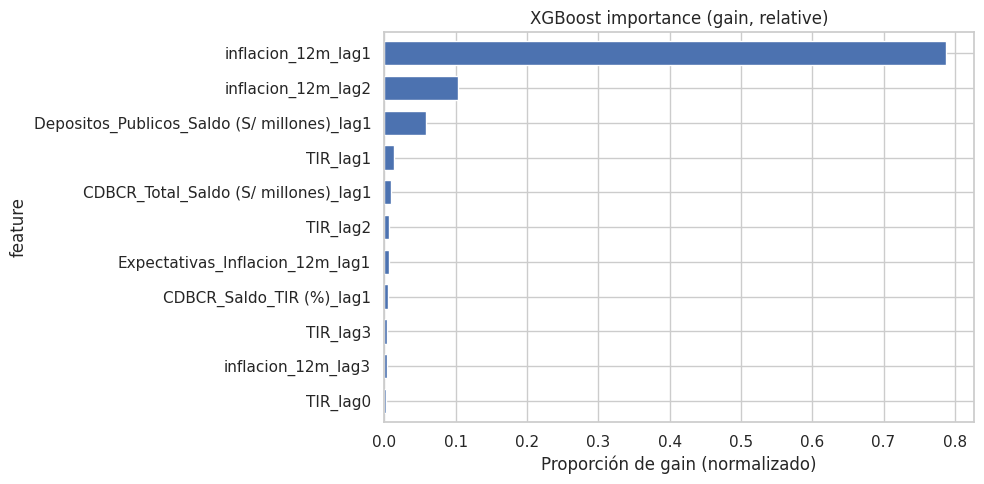

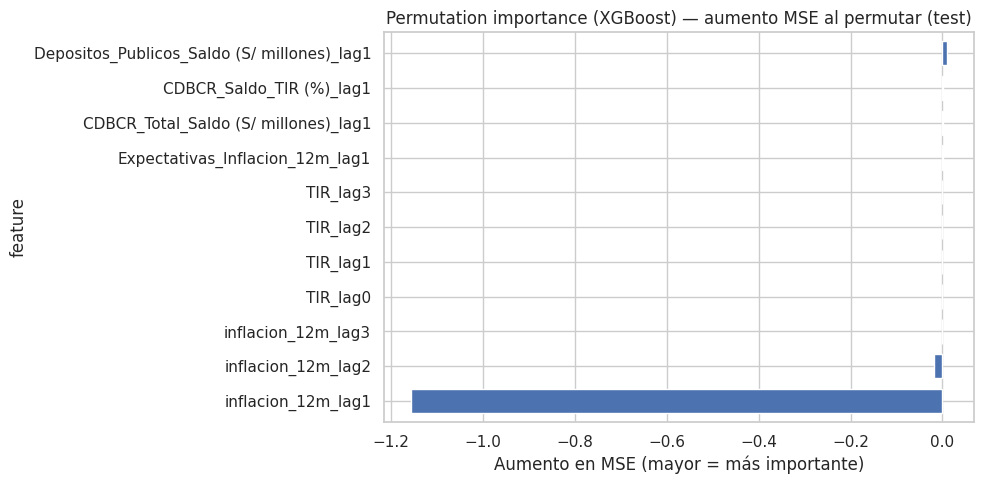

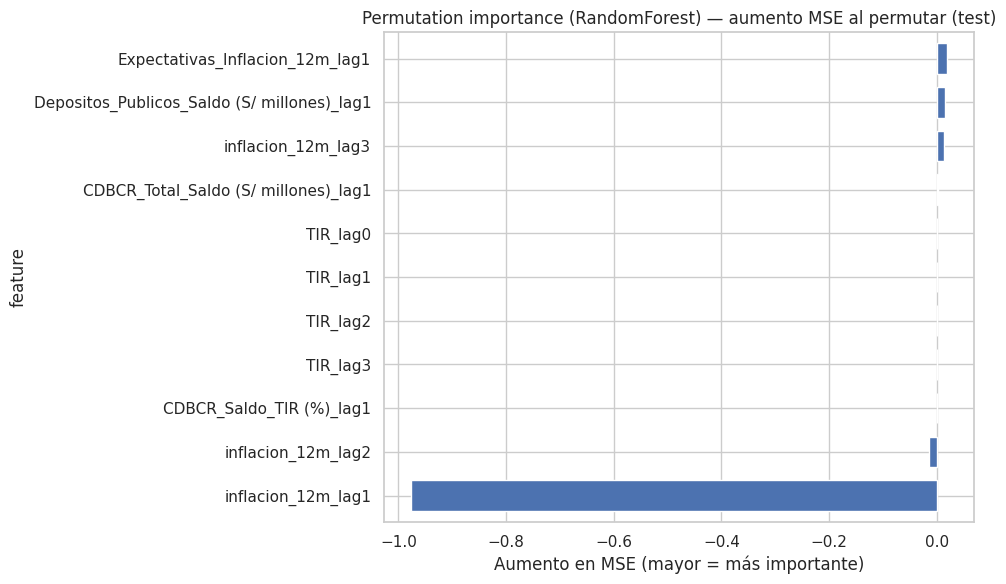

,XGB_gain_rel,Perm_XGBoost_mse_inc,Perm_RandomForest_mse_inc
Depositos_Publicos_Saldo (S/ millones)_lag1,0.058625,0.010494,0.014415
CDBCR_Saldo_TIR (%)_lag1,0.005328,0.002308,-0.000074
CDBCR_Total_Saldo (S/ millones)_lag1,0.008974,0.002026,0.001565
Expectativas_Inflacion_12m_lag1,0.005891,0.001051,0.019299
TIR_lag2,0.006448,-0.000000,-0.000000
TIR_lag0,0.002874,-0.000000,0.000368
TIR_lag1,0.013210,-0.000000,-0.000000
TIR_lag3,0.004335,-0.000000,-0.000000
inflacion_12m_lag3,0.003765,-0.001067,0.013352
inflacion_12m_lag2,0.103071,-0.017256,-0.015286


Resumen de importancias guardado en feature_importance_summary.csv


In [57]:
# ============================================================
# Feature importance: XGBoost (gain) + Permutation Importance
# ============================================================
sns.set(style='whitegrid')

# -----------------------------------------------------------------------------
# 1) IMPORTANCE from XGBoost (si usaste XGBRegressor)
# -----------------------------------------------------------------------------
try:
    # best_xgb debería existir (entrenado con RandomizedSearchCV)
    booster = getattr(best_xgb, 'get_booster', None)
    if booster is not None:
        # Extraer importancia por 'gain' (mejor reflecta la contribución)
        fmap = best_xgb.get_booster().get_score(importance_type='gain')
        fi_xgb = pd.DataFrame.from_dict(fmap, orient='index', columns=['gain']).rename_axis('feature').reset_index()
        # XGBoost devuelve nombres 'f0','f1' si se entrenó con numpy arrays.
        # Intentamos mapear a los nombres reales si están disponibles en X_train.columns
        # Si keys son f0..fn, reconstruimos mapping:
        if fi_xgb['feature'].str.startswith('f').all():
            # build mapping fN -> column name
            mapping = {f"f{i}": col for i, col in enumerate(X_train.columns)}
            fi_xgb['feature'] = fi_xgb['feature'].map(mapping)

        fi_xgb = fi_xgb.sort_values('gain', ascending=False).set_index('feature')
    else:
        fi_xgb = pd.DataFrame(columns=['gain'])
        print("best_xgb no tiene get_booster(): controle si es XGBRegressor real o fallback.")
except Exception as e:
    fi_xgb = pd.DataFrame(columns=['gain'])
    print("Error extrayendo importancias XGBoost:", e)

# Normalizar para comparar
if not fi_xgb.empty:
    fi_xgb['gain_rel'] = fi_xgb['gain'] / fi_xgb['gain'].sum()

# -----------------------------------------------------------------------------
# 2) Permutation Importance (model-agnostic) sobre el conjunto de test
# -----------------------------------------------------------------------------
# Usamos test set para medir impacto real sobre la predicción fuera de muestra
perm_results = {}

for name, model in [('XGBoost', best_xgb), ('RandomForest', best_rf)]:
    try:
        r = permutation_importance(model, X_test, y_test, n_repeats=30,
                                   random_state=RANDOM_STATE, scoring='neg_mean_squared_error', n_jobs=-1)
        perm_df = pd.DataFrame({
            'feature': X_test.columns,
            'import_mean': r.importances_mean,
            'import_std': r.importances_std
        }).sort_values('import_mean', ascending=False).set_index('feature')
        # Convert negative mean importance (because scorer is neg MSE) to positive effect on MSE
        perm_df['mse_increase'] = -perm_df['import_mean']  # positive = worse when permuted
        perm_results[name] = perm_df
    except Exception as e:
        print(f"Permutation importance falló para {name}:", e)
        perm_results[name] = pd.DataFrame()

# -----------------------------------------------------------------------------
# 3) Tabla combinada de importancias (XGBoost gain + Permutation RF/XGB)
# -----------------------------------------------------------------------------
# Build a single summary dataframe with columns:
# 'XGB_gain_rel', 'Perm_XGB_mse_inc', 'Perm_RF_mse_inc'
summary_df = pd.DataFrame(index=X_train.columns)

if not fi_xgb.empty:
    summary_df = summary_df.join(fi_xgb['gain_rel'].rename('XGB_gain_rel'))
else:
    summary_df['XGB_gain_rel'] = np.nan

for model_name in ['XGBoost','RandomForest']:
    if not perm_results[model_name].empty:
        summary_df[f'Perm_{model_name}_mse_inc'] = perm_results[model_name]['mse_increase']
    else:
        summary_df[f'Perm_{model_name}_mse_inc'] = np.nan

summary_df = summary_df.fillna(0).sort_values(by=['Perm_XGBoost_mse_inc' if 'Perm_XGBoost_mse_inc' in summary_df.columns else 'XGB_gain_rel'], ascending=False)

# -----------------------------------------------------------------------------
# 4) Plots: XGBoost gain + Permutation importance barplots
# -----------------------------------------------------------------------------
plt.figure(figsize=(10, 5))
if not fi_xgb.empty:
    fi_xgb['gain_rel'].sort_values(ascending=True).plot(kind='barh', width=0.7)
    plt.title('XGBoost importance (gain, relative)')
    plt.xlabel('Proporción de gain (normalizado)')
else:
    plt.text(0.5, 0.5, 'No hay importancias XGBoost', ha='center')
plt.tight_layout()
plt.show()

# Permutation importance for XGBoost (test)
if 'XGBoost' in perm_results and not perm_results['XGBoost'].empty:
    plt.figure(figsize=(10, 5))
    perm_results['XGBoost']['mse_increase'].sort_values(ascending=True).plot(kind='barh', width=0.7)
    plt.title('Permutation importance (XGBoost) — aumento MSE al permutar (test)')
    plt.xlabel('Aumento en MSE (mayor = más importante)')
    plt.tight_layout()
    plt.show()

# Permutation importance for RF (test)
if 'RandomForest' in perm_results and not perm_results['RandomForest'].empty:
    plt.figure(figsize=(10, 6))
    perm_results['RandomForest']['mse_increase'].sort_values(ascending=True).plot(kind='barh', width=0.7)
    plt.title('Permutation importance (RandomForest) — aumento MSE al permutar (test)')
    plt.xlabel('Aumento en MSE (mayor = más importante)')
    plt.tight_layout()
    plt.show()

# -----------------------------------------------------------------------------
# 5) Mostrar tablas resumen
# -----------------------------------------------------------------------------
display(summary_df.head(20))

# Guardar resultados (opcional)
summary_df.to_csv('feature_importance_summary.csv')
print("Resumen de importancias guardado en feature_importance_summary.csv")


Los resultados de importancia de variables son consistentes entre ambos métodos y refuerzan una conclusión central del trabajo: **la inflación subyacente peruana está fuertemente dominada por su persistencia en el muy corto plazo**.

Tanto la importancia por *gain* de XGBoost como la importancia por permutación coinciden en que:
- el primer rezago de la inflación subyacente $(π_{t-1})$ es, por amplio margen, la variable más relevante,
- seguido por el segundo rezago $(π_{t-2})$.

Esto es esperable en un esquema de nowcasting mensual: la inflación subyacente presenta ajustes graduales y alta inercia, por lo que los valores recientes contienen prácticamente toda la información necesaria para anticipar el mes siguiente.

Las variables de política monetaria del BCRP (tasa de referencia, CDBCR, depósitos públicos) y las expectativas de inflación muestran importancias significativamente menores. Este resultado no implica irrelevancia económica, sino que refleja que:
- sus efectos operan de manera acumulativa,
- y que, a frecuencia mensual, sus variaciones suelen ser pequeñas y altamente persistentes.

La permutación de πₜ₋₁ genera un aumento abrupto del MSE, lo que confirma que **los rezagos explican la mayor parte de la señal predictiva relevante en h = 1**. En Random Forest, algunas variables monetarias muestran incrementos moderados del error al ser permutadas, indicando que aportan información adicional cuando el modelo no puede apoyarse exclusivamente en la persistencia.

**Alcance y limitaciones:**

Este resultado no debe extrapolarse a horizontes más largos. En predicciones a 6 o 12 meses:
- los rezagos observados ya no están disponibles,
- el error se acumula en esquemas recursivos,
- y las expectativas, la política monetaria y los choques externos tienden a ganar relevancia.

Por ello, la lectura correcta es la siguiente:

> **En nowcasting de un mes, la persistencia domina la predicción; en horizontes más largos, la estructura causal y las variables monetarias adquieren un rol creciente.**

Esta evidencia refuerza la coherencia interna del proyecto y confirma que los resultados obtenidos son consistentes tanto desde una perspectiva econométrica como desde una lectura macroeconómica.



## **3.8. Resultados comparativos: desempeño predictivo y visualización**

En esta sección se presenta una comparación integral del desempeño predictivo de todos los modelos estimados a lo largo del trabajo, incluyendo:
- baselines simples,
- modelos lineales (OLS y Ridge),
- y modelos no lineales (Random Forest y XGBoost).

La evaluación se realiza exclusivamente sobre el **conjunto de prueba**, utilizando:
- **Error Cuadrático Medio (MSE)** como medida principal de precisión,
- **R² fuera de muestra** como indicador complementario de ajuste relativo.

Además de la comparación tabular, se incluye una visualización conjunta de las predicciones para analizar:
- la capacidad de cada modelo para seguir la trayectoria temporal de la inflación subyacente,
- la suavidad de las predicciones,
- y la presencia de desviaciones sistemáticas respecto a la serie observada.

Dado que el ejercicio corresponde a un **esquema one-step-ahead (h = 1)**, los resultados deben interpretarse en el contexto de una dinámica inflacionaria altamente persistente.


,Test_MSE,Test_R2
Baseline_Persistence,0.024966,0.973742
OLS,0.058149,0.938842
RidgeCV,0.058152,0.938838
Ridge_Grid,0.062487,0.934279
XGB,0.089084,0.906306
RF,0.148969,0.843322
Baseline_Mean,1.226592,-0.290066


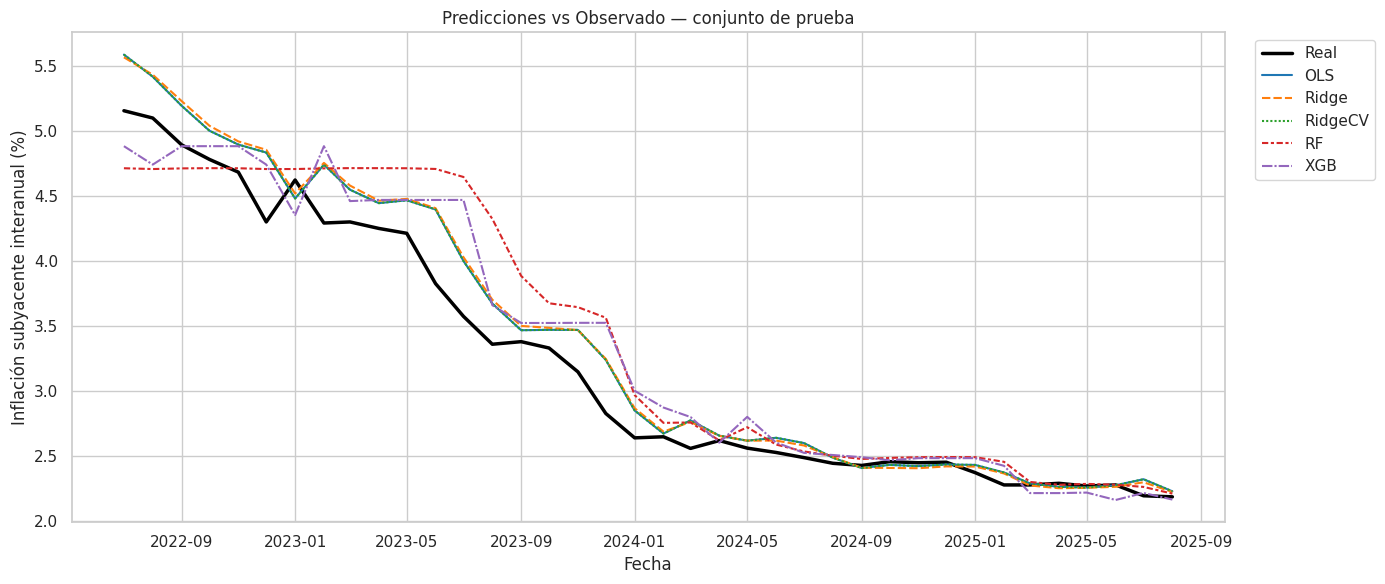

In [58]:
results = {
    'Baseline_Mean': (mse_base_mean, r2_base_mean),                 # Baseline: promedio histórico
    'Baseline_Persistence': (mse_persistence, r2_persistence),       # Baseline: persistencia (lag)
    'OLS': (mse_ols_test, r2_ols_test),                              # Resultados del modelo OLS
    'Ridge_Grid': (mse_ridge_test, r2_ridge_test),                   # Ridge ajustado con GridSearchCV
    'RidgeCV': (mean_squared_error(y_test, y_pred_ridgecv),
                r2_score(y_test, y_pred_ridgecv)),                   # RidgeCV
    'RF': (mse_rf_test, r2_rf_test),                                 # Random Forest
    'XGB': (mse_xgb_test, r2_xgb_test)                               # XGBoost
}

res_df = pd.DataFrame.from_dict(results, orient='index', columns=['Test_MSE','Test_R2'])
display(res_df.sort_values('Test_MSE'))   # Ordena modelos por menor error en test

df_preds = pd.DataFrame({
    'Real': y_test,                     # Valores reales
    'OLS': y_pred_ols,                  # Predicciones OLS
    'Ridge': y_pred_ridge,              # Predicciones Ridge GridSearch
    'RidgeCV': y_pred_ridgecv,          # Predicciones RidgeCV
    'RF': y_pred_rf,                    # Predicciones Random Forest
    'XGB': y_pred_xgb                   # Predicciones XGBoost
}, index=y_test.index)

plt.figure(figsize=(14,6))
sns.lineplot(data=df_preds['Real'], label='Real', color='black', linewidth=2.5)         # Serie real
sns.lineplot(data=df_preds.drop(columns=['Real']), palette='tab10', linewidth=1.5)      # Predicciones
plt.title('Predicciones vs Observado — conjunto de prueba')
plt.ylabel('Inflación subyacente interanual (%)')
plt.xlabel('Fecha')
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1))   # Leyenda fuera del gráfico
plt.tight_layout()
plt.show()    # Muestra comparación visual

La tabla y el gráfico de predicciones muestran un patrón claro y consistente: **la inflación subyacente presenta una dinámica altamente persistente y suavemente descendente**, lo que condiciona fuertemente el desempeño relativo de los modelos.

**1. Modelos lineales y regularizados**

Los modelos lineales —OLS, Ridge y RidgeCV— destacan como los más precisos y estables, con valores de MSE y R² muy cercanos entre sí y apenas por debajo del baseline de persistencia. Visualmente, sus predicciones reproducen casi exactamente la trayectoria observada, capturando tanto el nivel como la pendiente descendente de la serie.

Este resultado sugiere que, en este horizonte:
- la relación entre los predictores y la inflación subyacente es esencialmente lineal,
- la regularización mejora la estabilidad pero no altera sustancialmente la capacidad predictiva.

**2. Modelos no lineales**

XGBoost logra capturar adecuadamente la dirección general de la inflación, aunque introduce oscilaciones algo mayores que los modelos lineales. Esto se traduce en un error más alto, pero aún con un desempeño sólido fuera de muestra.

Random Forest presenta el menor rendimiento entre los modelos estructurados. Su arquitectura basada en árboles dificulta modelar una trayectoria suave y persistentemente descendente, lo que se refleja en predicciones más ruidosas y desviaciones visibles respecto a la serie real.

**3. Comparación con baselines**

El baseline de persistencia muestra un desempeño excepcionalmente alto, lo cual confirma que **la inercia inflacionaria domina la predicción en horizontes mensuales**. Esto no invalida los modelos econométricos, sino que establece un benchmark exigente: cualquier modelo debe, como mínimo, igualar la información contenida en πₜ₋₁.

El baseline de media histórica, en contraste, falla completamente, evidenciando que ignorar la dinámica temporal resulta inadecuado para este tipo de serie.

**4. Predicción one-step-ahead: aclaración conceptual**

Es importante enfatizar que el ejercicio utiliza un esquema **one-step-ahead**, donde la inflación del mes t se predice usando información disponible hasta t−1. Esto:
- no constituye una fuga de información,
- no es un ejercicio de nowcasting,
- y es estándar para evaluar capacidad predictiva inmediata.

Este esquema no debe extrapolarse a horizontes de 6 o 12 meses, donde:
- los rezagos observados dejan de estar disponibles,
- el error se acumula en predicciones recursivas,
- y las expectativas y la política monetaria adquieren mayor protagonismo.

En conjunto, los resultados indican que, para un horizonte mensual y una inflación caracterizada por alta persistencia:
- **los modelos lineales bien especificados ofrecen el mejor balance entre precisión, estabilidad e interpretabilidad**,
- mientras que los modelos no lineales no aportan mejoras sustantivas en este contexto.


# **TG 4. Análisis causal y modelación no lineal de la inflación**

## **4.1. Análisis causal: DAG de la inflación subyacente**

Si bien hemos incluido modelos no lineales, es fundamental explicitar la **estructura causal** que guía la dinámica de la inflación subyacente en el Perú. Para ello, se construye un *Directed Acyclic Graph* (DAG) que resume los principales canales económicos del esquema de metas de inflación del BCRP.

El DAG permite ordenar conceptualmente las relaciones entre persistencia inflacionaria, expectativas, política monetaria e instrumentos operativos, así como identificar variables omitidas relevantes —como la brecha del producto, el tipo de cambio real y los choques externos— que actúan como *confounders*. De este modo, el análisis causal complementa el enfoque predictivo previo y clarifica los supuestos implícitos en la especificación empírica.


In [59]:

!pip install git+https://github.com/daft-dev/daft.git


  Cloning https://github.com/daft-dev/daft.git to /tmp/pip-req-build-iy6jm65r
  Running command git clone --filter=blob:none --quiet https://github.com/daft-dev/daft.git /tmp/pip-req-build-iy6jm65r
  Resolved https://github.com/daft-dev/daft.git to commit 9221dfc6b7f6c19d49854688245d5182d9579480
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


<Axes: >

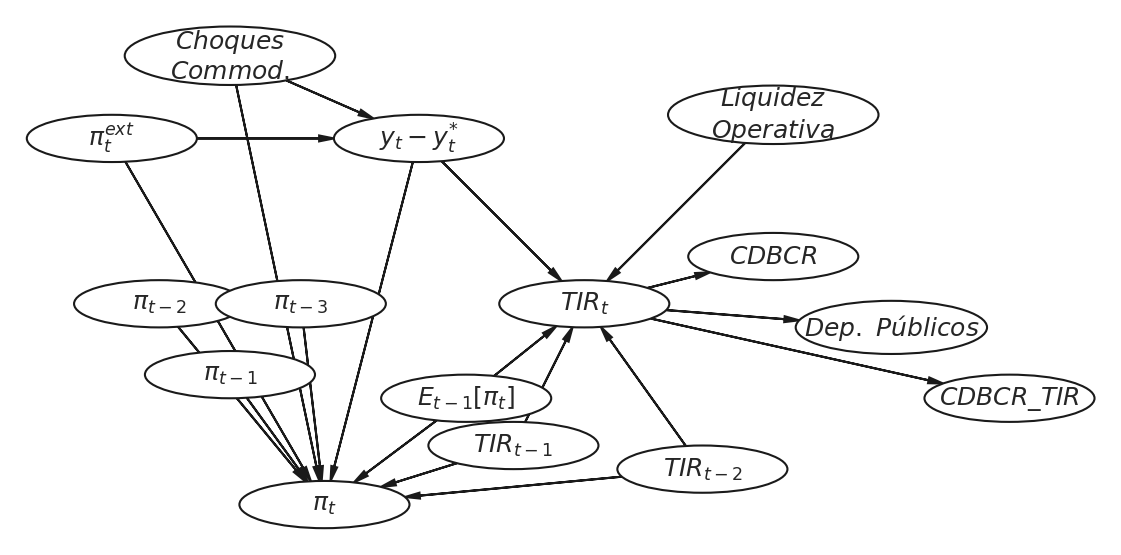

In [60]:
from daft import PGM, Node

# DAG
pgm = PGM(aspect=3.6, dpi=150)

# =====================================================
# 1. INFLACIÓN (PROCESO PERSISTENTE)
# =====================================================
pgm.add_node(Node("pi_lag1", r"$\pi_{t-1}$", 2.2, 1.4, scale=0.8))
pgm.add_node(Node("pi_lag2", r"$\pi_{t-2}$", 1.6, 2.0, scale=0.8))
pgm.add_node(Node("pi_lag3", r"$\pi_{t-3}$", 2.8, 2.0, scale=0.8))

pgm.add_node(Node("exp", r"$E_{t-1}[\pi_t]$", 4.2, 1.2, scale=0.8))

pgm.add_node(Node("pi_t", r"$\pi_t$", 3.0, 0.3, observed=False, scale=0.8))

# =====================================================
# 2. POLÍTICA MONETARIA — REACCIÓN
# =====================================================
pgm.add_node(Node("TIR_t", r"$TIR_t$", 5.2, 2.0, scale=0.8))

pgm.add_node(Node("TIR_lag1", r"$TIR_{t-1}$", 4.6, 0.8, scale=0.8))
pgm.add_node(Node("TIR_lag2", r"$TIR_{t-2}$", 5.8, 0.8, scale=0.8))

# IMPLEMENTACIÓN OPERATIVA (REUBICADA)
pgm.add_node(Node("CDBCR", r"$CDBCR$", 6.8, 2.4, scale=0.8))
pgm.add_node(Node("DepPub", r"$Dep.\ Públicos$", 7.8, 1.8, scale=0.9))
pgm.add_node(Node("CDBCR_TIR", r"$CDBCR\_TIR$", 8.8, 1.2, scale=0.8))



# =====================================================
# 4. CONFOUNDERS / SHOCKS EXÓGENOS
# =====================================================
pgm.add_node(Node("gap", r"$y_t - y_t^{*}$", 3.8, 3.4, scale=0.8))
pgm.add_node(Node("inf_ext", r"$\pi_t^{ext}$", 1.2, 3.4, scale=0.8))
pgm.add_node(Node("commod", "$Choques$\n$Commod.$", 2.2, 4.1, scale=0.99))
pgm.add_node(Node("liq", "$Liquidez$\n$Operativa$", 6.8, 3.6, scale=0.99))

# =====================================================
# 5. ARISTAS CAUSALES (ORDENADAS)
# =====================================================

# Persistencia inflacionaria
pgm.add_edge("pi_lag1", "pi_t")
pgm.add_edge("pi_lag2", "pi_t")
pgm.add_edge("pi_lag3", "pi_t")

# Expectativas
pgm.add_edge("exp", "pi_t")
pgm.add_edge("exp", "TIR_t")

# POLÍTICA MONETARIA — REACCIÓN (ajuste de posición)
pgm.add_node(Node("TIR_t", r"$TIR_t$", 5.2, 2.0, scale=0.8))
pgm.add_node(Node("TIR_lag1", r"$TIR_{t-1}$", 4.6, 0.8, scale=0.8))
pgm.add_node(Node("TIR_lag2", r"$TIR_{t-2}$", 6.2, 0.6, scale=0.8))  # desplazado a la derecha y abajo

# Flechas de persistencia institucional
pgm.add_edge("TIR_lag1", "TIR_t")
pgm.add_edge("TIR_lag2", "TIR_t")

# Flechas de transmisión monetaria
pgm.add_edge("TIR_lag1", "pi_t")
pgm.add_edge("TIR_lag2", "pi_t")


# Implementación operativa
pgm.add_edge("TIR_t", "CDBCR")
pgm.add_edge("TIR_t", "DepPub")
pgm.add_edge("TIR_t", "CDBCR_TIR")

# Confounders reales
pgm.add_edge("gap", "TIR_t")
pgm.add_edge("gap", "pi_t")
pgm.add_edge("inf_ext", "pi_t")
pgm.add_edge("inf_ext", "gap")
pgm.add_edge("commod", "pi_t")
pgm.add_edge("commod", "gap")

# Liquidez → capacidad de implementación
pgm.add_edge("liq", "TIR_t")

# =====================================================
# 6. RENDER
# =====================================================
pgm.render()

El diagrama causal resume la estructura conceptual que subyace al análisis empírico de la inflación subyacente en el Perú. La variable de interés es la inflación subyacente interanual,  $π_t$ , que captura la tendencia persistente de los precios excluyendo componentes altamente volátiles. El DAG integra tanto las variables observadas en el dataset como factores omitidos relevantes, con el objetivo de representar de manera coherente los principales canales económicos del esquema de metas de inflación del BCRP.

En primer lugar, los rezagos de la inflación ($ π_{t−1} ,  π_{t−2} ,  π_{t−3} $) aparecen como determinantes fundamentales de  πt . Esto refleja la elevada persistencia inflacionaria documentada en el análisis descriptivo y predictivo: la inflación subyacente evoluciona de manera gradual, de modo que el comportamiento pasado contiene información clave para explicar su dinámica de corto plazo.

Las expectativas de inflación a 12 meses,  $E_{t−1}[π_t]$ , constituyen un segundo canal central. En un régimen de metas de inflación creíble, empresas y hogares fijan precios y salarios anticipando la inflación futura, por lo que las expectativas influyen directamente sobre la inflación efectiva. Su inclusión en el DAG refleja el rol informativo y coordinador de la política monetaria en la formación de expectativas.

La tasa de interés de referencia ( TIR_t ) representa el principal instrumento de política monetaria del BCRP. A través de su impacto sobre las condiciones financieras, el crédito y la demanda agregada, la TIR afecta la inflación subyacente y contribuye a anclar las expectativas. En el DAG, la relación causal fluye desde la TIR hacia  πt , reflejando el canal tradicional de transmisión monetaria.

Las variables monetarias observadas en el dataset (CDBCR, depósitos del sector público y CDBCR_TIR) cumplen un rol operativo. Estas herramientas no constituyen instrumentos de política final, sino mecanismos mediante los cuales el BCRP gestiona la liquidez del sistema financiero para implementar la postura monetaria definida por la TIR. Por esta razón, se interpretan como variables subordinadas a la política monetaria, cuyo objetivo es asegurar que las condiciones de liquidez reproduzcan correctamente la señal de la tasa de referencia.

El DAG incorpora además un conjunto de variables omitidas conceptualmente relevantes que actúan como confounders. La brecha del producto ( $y^t−y*^t$ ) afecta directamente a la inflación, al capturar presiones de demanda, y simultáneamente influye en la reacción del BCRP, generando una relación causal tanto con  πt  como con la TIR. De manera similar, la inflación externa y los choques de commodities representan presiones de costos internacionales que inciden sobre la inflación doméstica y, a través de la actividad económica, sobre la postura de la política monetaria. El tipo de cambio real se incluye como un determinante adicional de la inflación, reflejando el canal de precios de bienes transables.

Un aspecto importante del DAG es la exclusión explícita de la tasa de interés interbancaria como nodo independiente. Si bien esta tasa desempeña un papel crucial en la implementación diaria de la política monetaria, desde un punto de vista causal no constituye un instrumento autónomo, sino una variable endógena de implementación. El BCRP no fija directamente la tasa interbancaria; en cambio, utiliza sus instrumentos de liquidez para inducir que esta se alinee con la tasa de referencia dentro del corredor de política. En este sentido, la tasa interbancaria es un resultado operativo de la TIR y de la gestión de liquidez, más que un determinante causal independiente de la inflación.

Esta decisión es consistente con la evidencia empírica presentada en el trabajo, donde se observa una correlación extremadamente alta entre la tasa de referencia y la tasa interbancaria, reflejo de una transmisión casi mecánica de la política monetaria. Incluir ambas variables como nodos separados introduciría redundancia y podría distorsionar la interpretación causal, sugiriendo una autonomía del canal interbancario que no existe en la práctica.

En conjunto, el DAG sintetiza de manera clara y estructurada los principales canales que determinan la inflación subyacente en el Perú: persistencia inflacionaria, expectativas, política monetaria, actividad económica y shocks externos. Esta representación conceptual proporciona el marco interpretativo que justifica tanto la especificación empírica de los modelos como los resultados predictivos obtenidos a lo largo del análisis.



## **4.2. MLP: Redes Neuronales**

En esta sección se evalúa un modelo de red neuronal artificial tipo MLP como contraste metodológico frente a los enfoques lineales y de árboles previamente analizados. El objetivo no es maximizar la capacidad predictiva per se, sino verificar si un modelo altamente flexible y no paramétrico logra capturar relaciones no lineales relevantes en la dinámica de la inflación subyacente.

El MLP se entrena bajo un esquema de validación cruzada temporal, con estandarización previa de las variables, y se explora un conjunto amplio de hiperparámetros que incluye distintas arquitecturas de capas ocultas, funciones de activación, algoritmos de optimización y niveles de regularización. Este diseño garantiza que el modelo tenga suficiente flexibilidad para aprender patrones complejos, sin introducir fugas de información temporal.

Fitting 5 folds for each of 405 candidates, totalling 2025 fits
Mejores hiperparámetros MLP: {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': (128, 64), 'learning_rate_init': 0.001, 'solver': 'lbfgs'}
Mejor CV MSE: 0.0735563806004177
MLP Test MSE: 0.138688
MLP Test R²: 0.854135


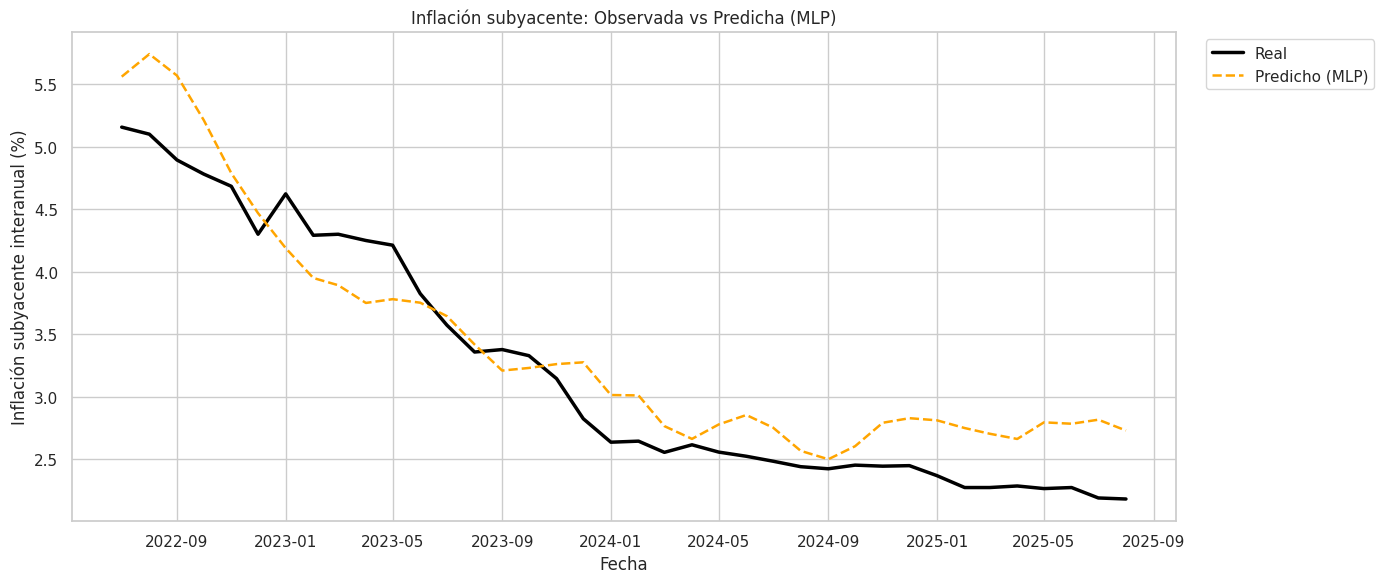

In [30]:
# ===========================
# 12. MLP - Redes Neuronales
# ===========================

# ---------------------------
# Escalamiento
# ---------------------------
scaler_mlp = StandardScaler()
X_train_scaled = scaler_mlp.fit_transform(X_train)
X_test_scaled = scaler_mlp.transform(X_test)

# ---------------------------
# Definición del MLP base
# ---------------------------
mlp_base = MLPRegressor(max_iter=2000, random_state=RANDOM_STATE)

# ---------------------------
# Hiperparámetros a buscar
# ---------------------------
param_grid = {
    'hidden_layer_sizes': [(32,), (64,), (64,32), (128,64), (128,64,32)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'lbfgs', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],  # regularización L2
    'learning_rate_init': [0.001, 0.01, 0.05]
}

# ---------------------------
# Validación temporal
# ---------------------------
tscv_mlp = TimeSeriesSplit(n_splits=5)

# ---------------------------
# GridSearchCV
# ---------------------------
grid_mlp = GridSearchCV(
    estimator=mlp_base,
    param_grid=param_grid,
    cv=tscv_mlp,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# ---------------------------
# Entrenamiento
# ---------------------------
grid_mlp.fit(X_train_scaled, y_train)

print("Mejores hiperparámetros MLP:", grid_mlp.best_params_)
print("Mejor CV MSE:", -grid_mlp.best_score_)

# ---------------------------
# Predicción con el mejor modelo
# ---------------------------
best_mlp = grid_mlp.best_estimator_
y_pred_mlp = best_mlp.predict(X_test_scaled)

mse_mlp = mean_squared_error(y_test, y_pred_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)
print(f"MLP Test MSE: {mse_mlp:.6f}")
print(f"MLP Test R²: {r2_mlp:.6f}")

# ---------------------------
# Gráfico Real vs Predicho
# ---------------------------

df_mlp_pred = pd.DataFrame({
    'Real': y_test,
    'Predicho (MLP)': y_pred_mlp
}, index=y_test.index)

plt.figure(figsize=(14,6))
sns.lineplot(data=df_mlp_pred['Real'], label='Real', color='black', linewidth=2.5)
sns.lineplot(data=df_mlp_pred['Predicho (MLP)'], label='Predicho (MLP)', color='orange', linewidth=1.8, linestyle='--')
plt.title('Inflación subyacente: Observada vs Predicha (MLP)')
plt.ylabel('Inflación subyacente interanual (%)')
plt.xlabel('Fecha')
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.show()



El modelo MLP optimizado selecciona una arquitectura de **dos capas ocultas (128, 64)**, con función de activación **logística**, regularización moderada $(\alpha = 0.01$) y el solver **lbfgs**, lo que sugiere un compromiso entre flexibilidad no lineal y suavizamiento de la serie. La validación cruzada temporal arroja un **MSE bajo (≈ 0.074)**, indicando que el modelo logra capturar adecuadamente la estructura promedio de la inflación subyacente en el período de entrenamiento.

En el conjunto de prueba, el MLP alcanza un **Test MSE ≈ 0.139** y un **$R^2 ≈ 0.85$**, lo que evidencia un buen desempeño predictivo fuera de muestra. Sin embargo, este resultado no supera al de los modelos lineales (OLS y Ridge), que continúan mostrando mayor precisión. Esta diferencia es consistente con la naturaleza del proceso inflacionario subyacente, caracterizado por **alta persistencia y relaciones esencialmente lineales** en horizontes cortos $(h = 1$).

Desde una perspectiva económica, el MLP tiende a generar trayectorias más suaves, lo que puede atenuar la velocidad de ajuste ante cambios abruptos en la dinámica inflacionaria. Por ello, aunque el modelo logra capturar patrones no lineales de manera razonable, su aporte es principalmente **complementario**. En conjunto, los resultados refuerzan la idoneidad de los modelos lineales como referencia principal, y sitúan al MLP como una herramienta útil para contrastar robustez, más que como una alternativa superior de pronóstico.


In [31]:

# ---------------------------
# Crear DataFrame con métricas
# ---------------------------
results_all = {
    'Baseline_Mean': (mse_base_mean, r2_base_mean),
    'Baseline_Persistence': (mse_persistence, r2_persistence),
    'OLS': (mse_ols_test, r2_ols_test),
    'Ridge_Grid': (mse_ridge_test, r2_ridge_test),
    'RidgeCV': (mean_squared_error(y_test, y_pred_ridgecv), r2_score(y_test, y_pred_ridgecv)),
    'Random_Forest': (mse_rf_test, r2_rf_test),
    'XGBoost': (mse_xgb_test, r2_xgb_test),
    'MLP': (mse_mlp, r2_mlp)
}

res_df_all = pd.DataFrame.from_dict(results_all, orient='index', columns=['Test_MSE', 'Test_R2'])
res_df_all = res_df_all.sort_values('Test_MSE')
display(res_df_all)






,Test_MSE,Test_R2
Baseline_Persistence,0.024966,0.973742
OLS,0.058149,0.938842
RidgeCV,0.058152,0.938838
Ridge_Grid,0.062487,0.934279
XGBoost,0.089084,0.906306
MLP,0.138688,0.854135
Random_Forest,0.148969,0.843322
Baseline_Mean,1.226592,-0.290066



Los resultados comparativos confirman que la inflación subyacente es un proceso altamente persistente y predominantemente lineal en horizontes cortos. El modelo de persistencia y los modelos lineales (OLS y Ridge) presentan el mejor desempeño predictivo, con MSE bajos y R² elevados, lo que indica que gran parte de la dinámica inflacionaria está explicada por su propia historia y por relaciones estables entre las variables. Este resultado es coherente con un régimen de metas de inflación creíble, donde la inercia y la reacción sistemática de la política monetaria dominan el corto plazo.

Los modelos no lineales —XGBoost, Random Forest y MLP— aportan valor como contraste metodológico, pero no superan a los enfoques lineales. En particular, el MLP logra capturar la tendencia general de la inflación subyacente, aunque con menor precisión, reflejando su dificultad para explotar ganancias adicionales en un proceso con baja no linealidad. Aun así, su desempeño es consistente y no sugiere sobreajuste, lo que respalda su uso como herramienta complementaria.

En conjunto, la evidencia indica que, para horizontes de predicción cortos (h = 1), los modelos parsimoniosos resultan más eficientes que algoritmos complejos. Como posibles extensiones, se podrían explorar enfoques en dos etapas que separen explícitamente la componente persistente de la inflación y modelen los residuos con información adicional, así como arquitecturas dinámicas más flexibles (por ejemplo, LSTM) para evaluar si capturan mejor ajustes no lineales en horizontes más largos. Estas extensiones quedan fuera del alcance del presente estudio, pero representan líneas naturales para investigaciones futuras.
